# AIML CA2
## Time Series Analysis

Name: Glenn Wu
Adm. No: 2214395
Class: DAAA/FT/2A/01

ARIMA and SARIMAX use different fitting methods https://stats.stackexchange.com/questions/374845/python-arima-generates-different-predictions-than-sarimax-for-same-orders

In [1]:
end_date = "2023-07-01" # 6 months from January 2023

In [44]:
import warnings
warnings.filterwarnings("ignore")

import pickle

In [3]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import statsmodels

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
# from pmdarima.arima import CHTest, nsdiffs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import q_stat, acf, pacf

In [6]:
# Custom date parsing function to get M/D/Y
def custom_date_parser(date_string):
    day, month, year = date_string.split('/')
    
    return pd.to_datetime(f'{day}/{month}/{year}', format='%d/%m/%Y')

df = pd.read_csv("Energy Consumption Dataset.csv", parse_dates=['DATE'], date_parser=custom_date_parser).set_index("DATE")
df.index = pd.DatetimeIndex(df.index, freq='MS')

# Exploratory Data Analysis

We will begin by conducting an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.

The dataset is about Energy Consumption, likely collected by a utilities company. There are 397 rows and 2 columns.<br>
**Gas Consumption (tons)**: Gas consumption in tons<br>
**Electricity Consumption (MWh)**: Electricity consumption in MWh<br>
**Water Consumption (tons)**: Water consumption in tons<br>

In [7]:
eda_df = df.copy()
eda_df.head(10)

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
1990-01-01                    18.0                          725.1   
1990-02-01                    15.8                          706.7   
1990-03-01                    17.3                          624.5   
1990-04-01                    18.9                          574.7   
1990-05-01                    22.0                          553.2   
1990-06-01                    23.4                          580.9   
1990-07-01                    24.6                          626.2   
1990-08-01                    24.8                          632.5   
1990-09-01                    23.8                          605.8   
1990-10-01                    20.2                          563.2   

            Water Consumption (tons)  
DATE                                  
1990-01-01                     548.8  
1990-02-01                     640.7  
1990-03-01                     511.1  
1990-04-01                     515.3  
1990-05-01                     488.4  
1990-06-01                     503.2  
1990-07-01                     448.3  
1990-08-01                     411.7  
1990-09-01                     440.8  
1990-10-01                     579.0

In [8]:
eda_df.describe()

Gas Consumption (tons)  Electricity Consumption (MWh)  \
count              397.000000                     397.000000   
mean                23.785139                     888.472544   
std                  4.903452                     153.877594   
min                 11.600000                     553.200000   
25%                 20.200000                     771.100000   
50%                 23.500000                     897.800000   
75%                 27.900000                    1005.200000   
max                 46.000000                    1294.000000   

       Water Consumption (tons)  
count                397.000000  
mean                 484.953652  
std                  133.908863  
min                   44.400000  
25%                  384.400000  
50%                  487.400000  
75%                  580.200000  
max                  811.000000

In [9]:
eda_df.dtypes

Gas Consumption (tons)           float64
Electricity Consumption (MWh)    float64
Water Consumption (tons)         float64
dtype: object

In [10]:
# Check missing values
eda_df.isnull().sum()

Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

No missing values to fill

In [11]:
# Get the column names of numeric columns
numeric_columns = df.select_dtypes(include=[int, float]).columns.tolist()

numeric_columns

['Gas Consumption (tons)',
 'Electricity Consumption (MWh)',
 'Water Consumption (tons)']

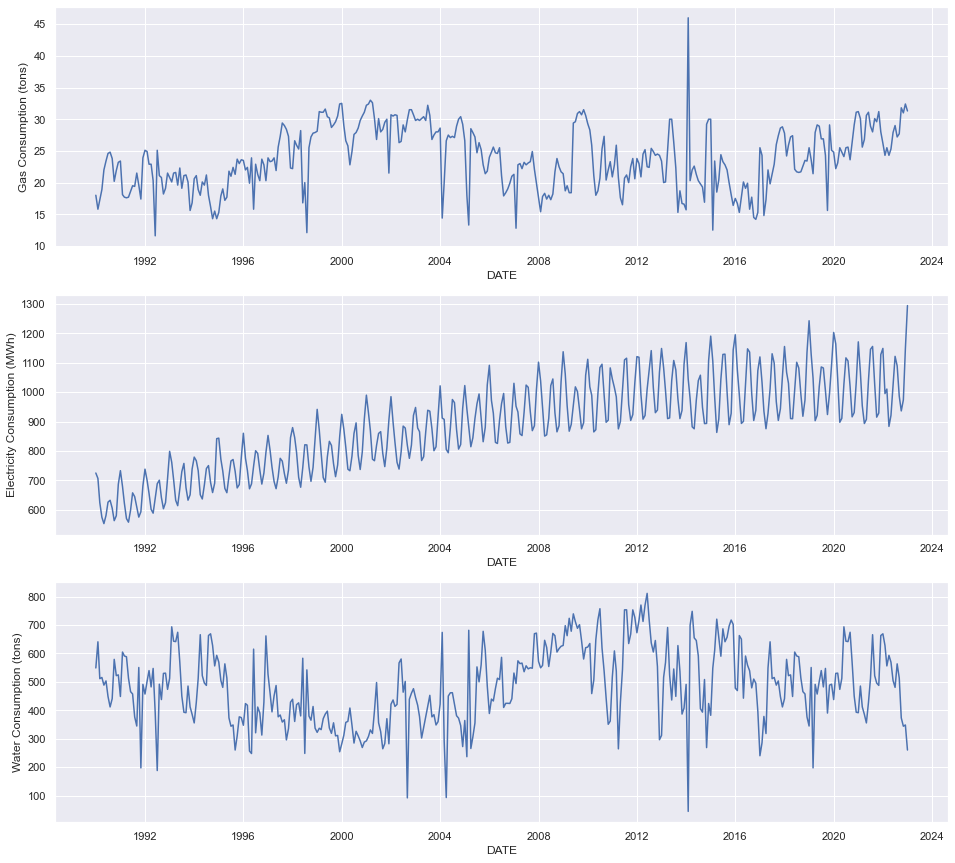

In [12]:
sns.set()

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(16, 15))

for i, col in enumerate(numeric_columns):
    sns.lineplot(data=eda_df.reset_index(), x="DATE", y=col, ax=axes[i])
plt.show()

## Gas Consumption

In [13]:
gas_consumption_series = df["Gas Consumption (tons)"]
electricity_consumption_series = df["Electricity Consumption (MWh)"]
water_consumption_series = df["Water Consumption (tons)"]

In [14]:
from scipy import stats

def visualisations(series, label="Time Series Data"):

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))

    # Histogram
    sns.histplot(series, bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {label}')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlabel(f"{label} (Skewness: {series.skew()})")

    # Q-Q plot
    stats.probplot(series, dist='norm', plot=axes[1])
    axes[1].set_title('Q-Q Plot')
    axes[1].set_xlabel('Theoretical Quantiles')
    axes[1].set_ylabel('Sample Quantiles')
    plt.show()

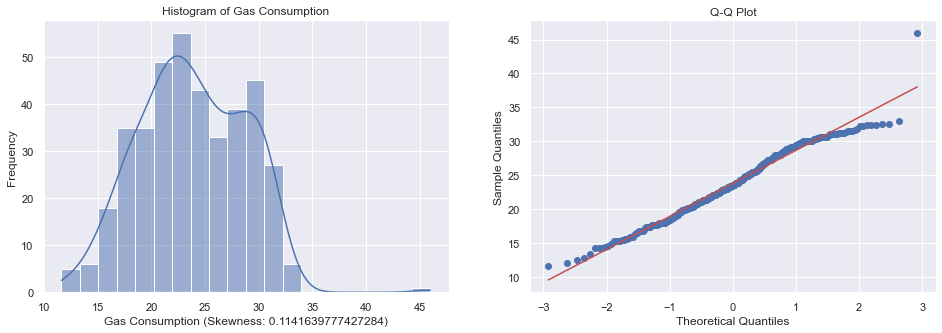

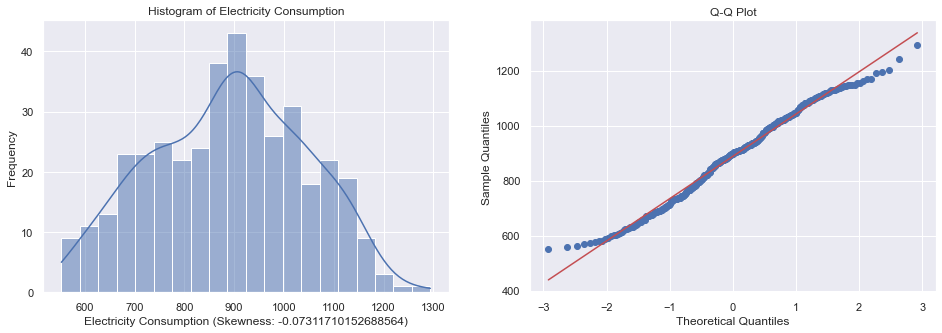

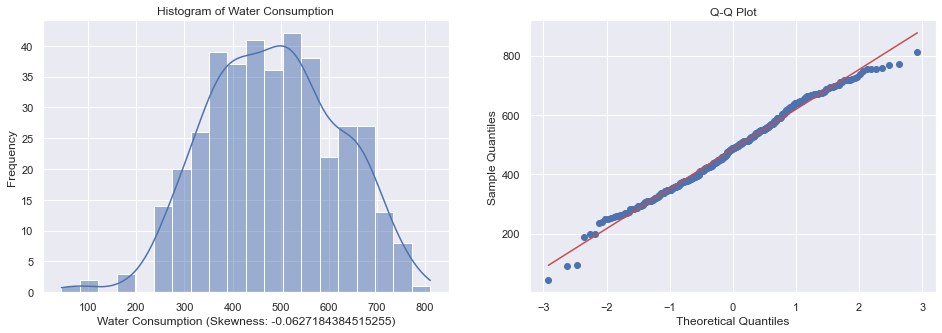

In [15]:
visualisations(gas_consumption_series, "Gas Consumption")
visualisations(electricity_consumption_series, "Electricity Consumption")
visualisations(water_consumption_series, "Water Consumption")

**Observations**
* All the time series have a similar distribution, based on QQ Plot
* The times series all have distributions that are neearly normal distributions
* Low (<0.5) skew

In [16]:
class NullTransformer:
    def __init__(self):
        return
    def fit_transform(self, X):
        return X
    def inverse_transform(self, X):
        return X
    
class LogTransformer:
    def __init__(self):
        return
    def fit_transform(self, X):
        return np.log(X)
    def inverse_transform(self, X):
        return np.exp(X)

pt = NullTransformer()

def transform_series(series, transformer):
    a = transformer.fit_transform(np.array(series).reshape(-1, 1))
    x = pd.Series([x[0] for x in a])
    x.index = series.index
    return x

def reverse_transform_series(series, transformer):
    a = transformer.inverse_transform(np.array(series).reshape(-1, 1))
    x = pd.Series([x[0] for x in a])
    x.index = series.index
    return x


b = transform_series(gas_consumption_series, pt)
reverse_transform_series(b, pt)

DATE
1990-01-01    18.0
1990-02-01    15.8
1990-03-01    17.3
1990-04-01    18.9
1990-05-01    22.0
              ... 
2022-09-01    27.7
2022-10-01    31.8
2022-11-01    31.0
2022-12-01    32.4
2023-01-01    31.3
Freq: MS, Length: 397, dtype: float64

#### Yeo-Johnson Transformation
$
Y(\lambda) =
\begin{cases}
\left((1 + \lambda) \cdot Y + 1\right)^{\frac{1}{\lambda}} - 1, & \text{if } \lambda \neq 0 \text{ and } Y \geq 0, \\
\log(1 + Y), & \text{if } \lambda = 0 \text{ and } Y \geq 0, \\
-\left((-Y + 1)^{2 - \lambda} - 1\right), & \text{if } \lambda \neq 2 \text{ and } Y < 0, \\
-\log(-Y + 1), & \text{if } \lambda = 2 \text{ and } Y < 0,
\end{cases}
$

where:
- $Y$ is the original data value.
- $\lambda$ is the transformation parameter that determines the type and amount of transformation. It can take any real value, including zero.

Time series prediction methods like SARIMA and VARMA assume that the residuals are normally distributed. Transforming the data using the Yeo-Johnson transformation can help achieve a more normal distribution.

The transformed values are usually more symmetric and have more stable variance compared to the original data.

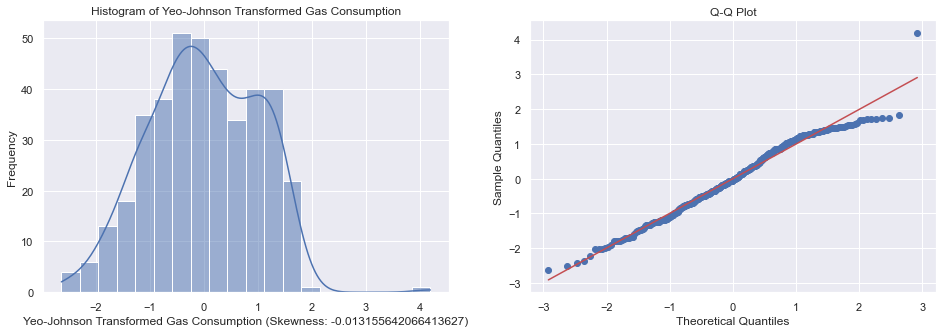

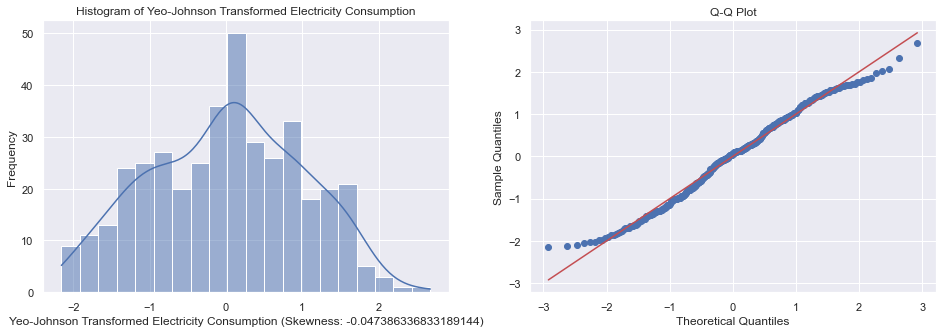

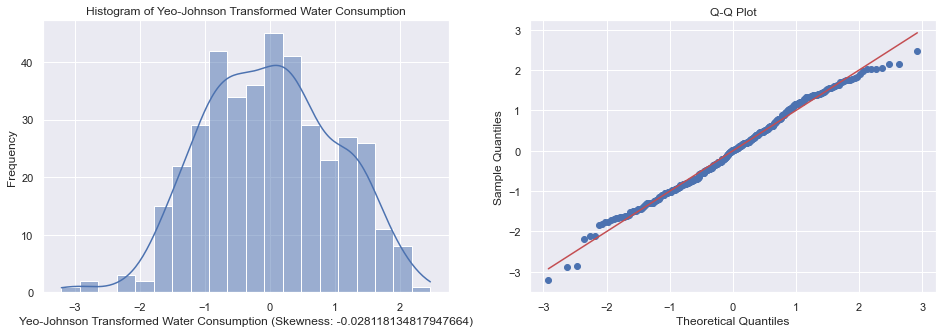

In [17]:
gas_pt = PowerTransformer()
electricity_pt = PowerTransformer()
water_pt = PowerTransformer()

# gas_pt = NullTransformer()
# electricity_pt = NullTransformer()
# water_pt = NullTransformer()

# gas_pt = LogTransformer()
# electricity_pt = LogTransformer()
# water_pt = LogTransformer()

gas_consumption_series = transform_series(gas_consumption_series, gas_pt)
electricity_consumption_series = transform_series(electricity_consumption_series, electricity_pt)
water_consumption_series = transform_series(water_consumption_series, water_pt)

visualisations(gas_consumption_series, "Yeo-Johnson Transformed Gas Consumption")
visualisations(electricity_consumption_series, "Yeo-Johnson Transformed Electricity Consumption")
visualisations(water_consumption_series, "Yeo-Johnson Transformed Water Consumption")

#### Pearson's r Correlations

To check for correlation between three series, we use Pearson's r correlation coefficient. It is able to measure the linear correlation between the two variables.

The r value of X and Y is equal to diving the covriance of X and Y by the product of their standard deviations.

Formula:
\begin{equation}
\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}
\end{equation}

\begin{equation}
r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}
\end{equation}

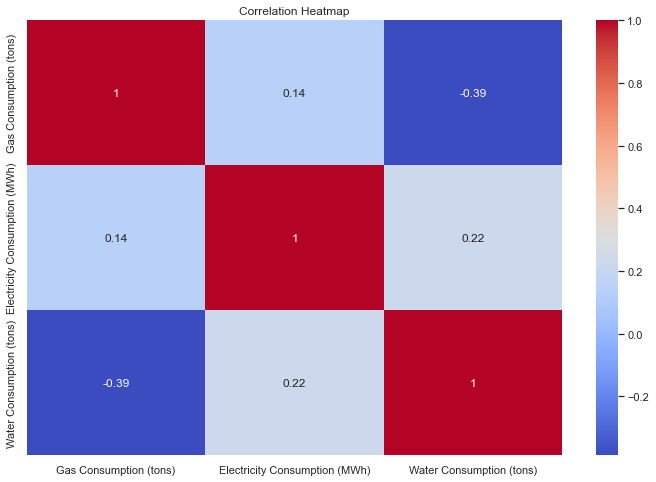

In [18]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(eda_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [19]:
def seasonal_diff(series, seasonal_period=12, return_discard=False):
    x = np.array(series[seasonal_period:])-np.array(series[:-seasonal_period])
    x = pd.Series(x)
    x.index = series[seasonal_period:].index
    if return_discard:
        return x, series[:seasonal_period]
    else:
        return x
    
def seasonal_diff_order(series, order, seasonal_period=12, return_discards=True):
    x = series
    discards = []
    for i in range(order):
        x, discard = seasonal_diff(x, seasonal_period=seasonal_period, return_discard=True)
        discards.append(discard)
    if return_discards:
        return x, discards
    else:
        return x
    
def reverse_seasonal_diff(diffed, discard, seasonal_period=12):
    x = discard.append(diffed)
    for i in range(seasonal_period):
        x[i::seasonal_period] = np.cumsum(x[i::seasonal_period])
    return x

def reverse_seasonal_diff_order(diffed, discards, seasonal_period=12):
    x = reverse_seasonal_diff(diffed, discards[-1], seasonal_period=seasonal_period)
    discards = discards[:-1]
    if discards == []:
        return x
    else:
        return reverse_seasonal_diff_order(x, discards, seasonal_period=seasonal_period)
    
# find the combination of differencing orders that minimizes standard deviation
def find_best_diff_order(series, max_d=3, max_D=3, max_M=24, seasonal_period=12):
    # maximum d+D = 2
    scores = []
    for d in range(max_d):
        for D in range(max_D):
            for M in range(2, max_M):
                scores.append(np.std(seasonal_diff_order(seasonal_diff_order(series, d, seasonal_period=1, return_discards=False), D, seasonal_period=M, return_discards=False)))
#                 print(scores[-1], d, D, M)
    dD, M = np.divmod(np.argmin(scores), max_M-2)
    M += 2
    return np.divmod(dD, max_D), M

def k_diff(series, d, D, seasonal_period=12, return_discards=False):
    normal_diff_series, normal_discards = seasonal_diff_order(series, d, seasonal_period=1, return_discards=True)
    seasonal_diff_series, seasonal_discards = seasonal_diff_order(normal_diff_series, D, seasonal_period=seasonal_period, return_discards=True)
    if return_discards:
        return seasonal_diff_series, normal_discards, seasonal_discards
    else: 
        return seasonal_diff_series
    
def k_undiff(series, normal_discards, seasonal_discards, seasonal_period=12):
    undiff_normal = reverse_seasonal_diff_order(series, normal_discards, seasonal_period=1)
    if seasonal_discards == None:
        return undiff_normal
    else:
        return reverse_seasonal_diff_order(undiff_normal, seasonal_discards, seasonal_period=seasonal_period)

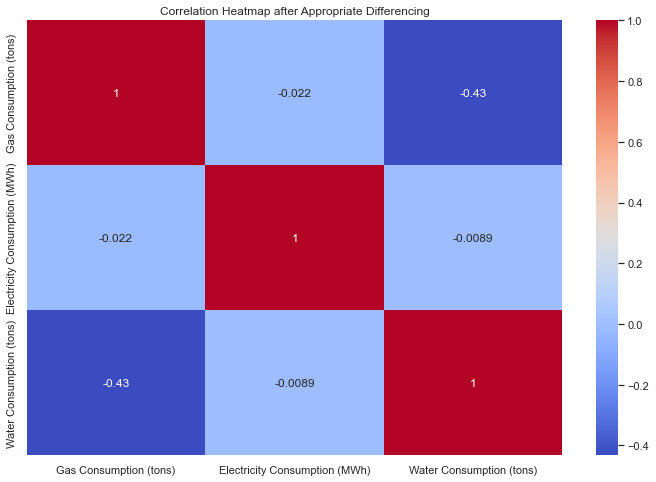

In [20]:
differenced_eda_df = eda_df.copy()

differenced_eda_df["Gas Consumption (tons)"] = k_diff(differenced_eda_df["Gas Consumption (tons)"], 1, 0)
differenced_eda_df["Electricity Consumption (MWh)"] = k_diff(differenced_eda_df["Electricity Consumption (MWh)"], 1, 1)
differenced_eda_df["Water Consumption (tons)"] = k_diff(differenced_eda_df["Water Consumption (tons)"], 1, 0)

differenced_eda_df = differenced_eda_df.dropna()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(differenced_eda_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap after Appropriate Differencing')
plt.show()

**Observations**
* Since Water and Gas consumption are moderately negatively correlated I will explore using a VARMAX model on them. 
* Electricity consumption has a very low, near zero, correlation with these columns after differencing for stationarity.

### Statistical Test for Causality

--------------------
#### Granger Causality Test
Hypotheses:
<br>$H_0$: The lagged values of variable X do not cause the values of variable Y.
<br>$H_A$: The lagged values of variable X do Granger cause the values of variable Y.
--------------------

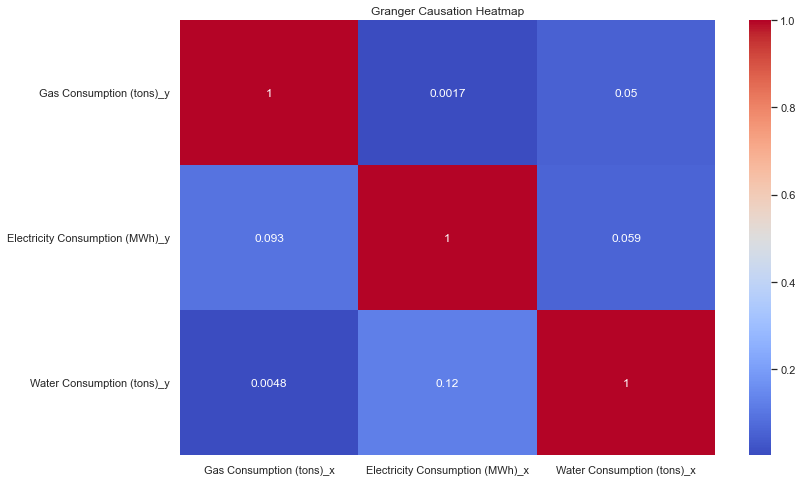

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=30
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            df.loc[r, c] = np.min(p_values)
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

plt.figure(figsize=(12, 8))
sns.heatmap(grangers_causation_matrix(differenced_eda_df, variables = differenced_eda_df.columns), annot=True, cmap='coolwarm')
plt.title('Granger Causation Heatmap')
plt.show()

Based on a 0.05 significance level, we can conclude that Gas Consumption causes Water Consumption and Electricity Consumption causes Gas Consumption.

### Seasonality
Seasonality in the time series can be used to enhance predictions. There are many methods to determine a suitable seasonal period. The first method I will use is to use the ```seasonal_decompose()``` function to find the seasonal component for a range of seasonal periods then calculate the standard deviation of this component. The standard deviation of a component at a suitable period should tend to be greater as it makes up a greater part of the time series.

In [22]:
def find_seasonal_period(series, title="", period_range=range(2, 50), **kwargs):
    plt.figure(**kwargs)
    # ranges = []
    seasonal_stds = []
    residual_stds = []
    for i in period_range:
        decompose_data = seasonal_decompose(series, model="add", period=i)
    #     ranges.append(np.max(decompose_data.seasonal)-np.min(decompose_data.seasonal))
        seasonal_stds.append(np.std(decompose_data.seasonal[:i]))
        residual_stds.append(np.std(decompose_data.resid.dropna()))
    sns.lineplot(x=list(period_range), y=seasonal_stds)
    if title != "":
        plt.title(title)
    plt.xlabel(f"Seasonal period with the greatest standard deviation of seasonal component: {list(period_range)[np.argmax(seasonal_stds)]}")
    plt.show()
#     print()

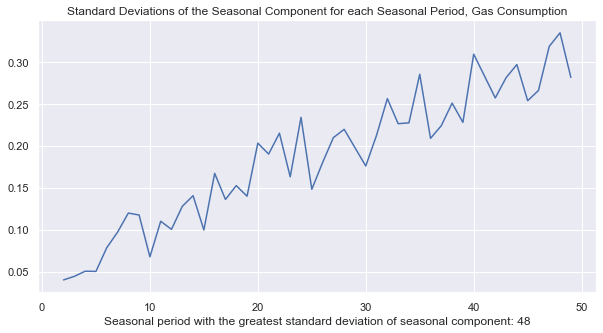

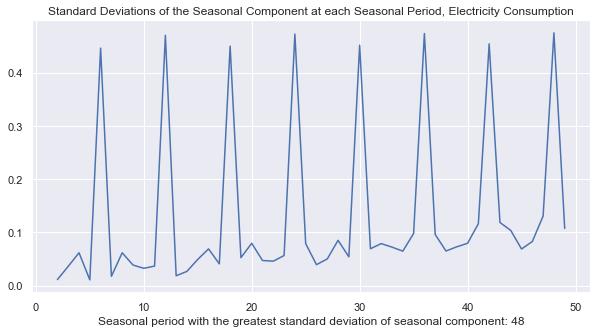

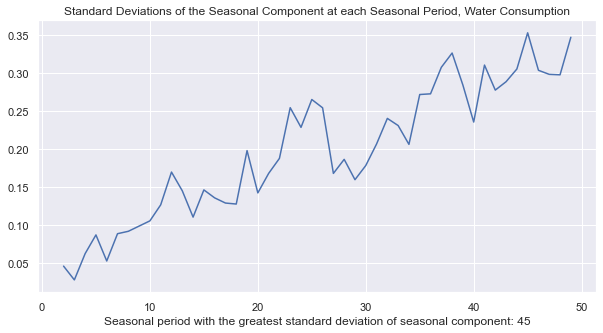

In [23]:
find_seasonal_period(gas_consumption_series, title="Standard Deviations of the Seasonal Component for each Seasonal Period, Gas Consumption", figsize=(10, 5))
find_seasonal_period(electricity_consumption_series, title="Standard Deviations of the Seasonal Component at each Seasonal Period, Electricity Consumption", figsize=(10, 5))
find_seasonal_period(water_consumption_series, title="Standard Deviations of the Seasonal Component at each Seasonal Period, Water Consumption", figsize=(10, 5))

**Observations**
* For Gas and Water consumption, it is difficult to see any trend and it generally seems like standard deviation increases with the seasonal period.
* For Electricity consumption, there is an obvious trend where seasonal periods that are multiples of 6 (eg. 12, 18, 24) have a much greater standard deviation. Multiples of 12 seem to have an even greater standard deviation, thus I will use 12 as the seasonal period for this series.

In [24]:
def seasonal_decompose_plot(series, title, **kwargs):
    decompose_data = seasonal_decompose(series, **kwargs)
    x = decompose_data.plot()
    x.set_size_inches(16, 10)
    x.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
    x.suptitle(title, fontsize=18)
    plt.show()
    return decompose_data

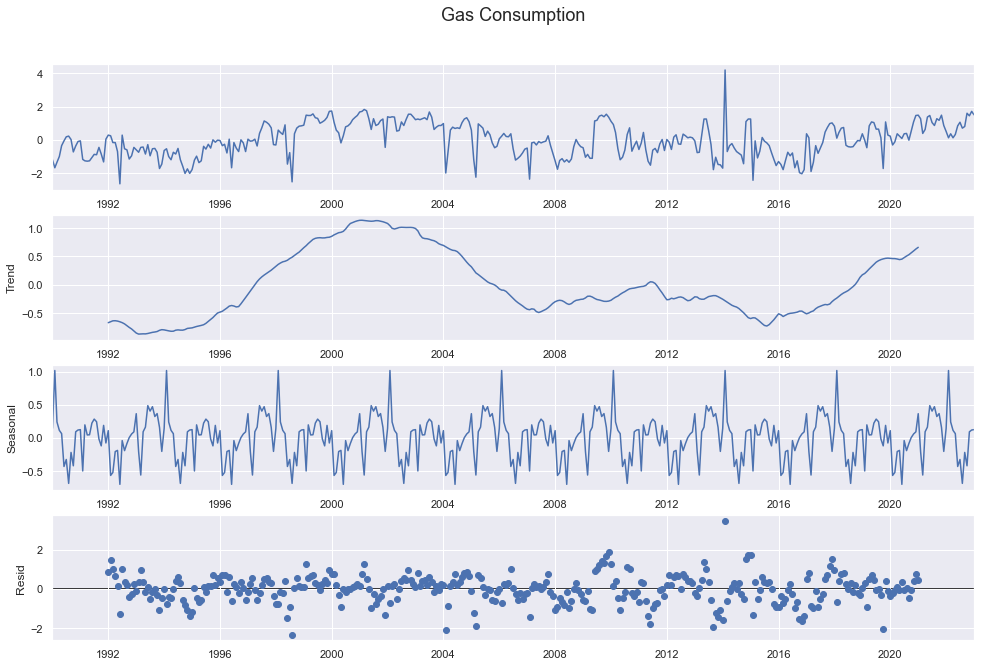

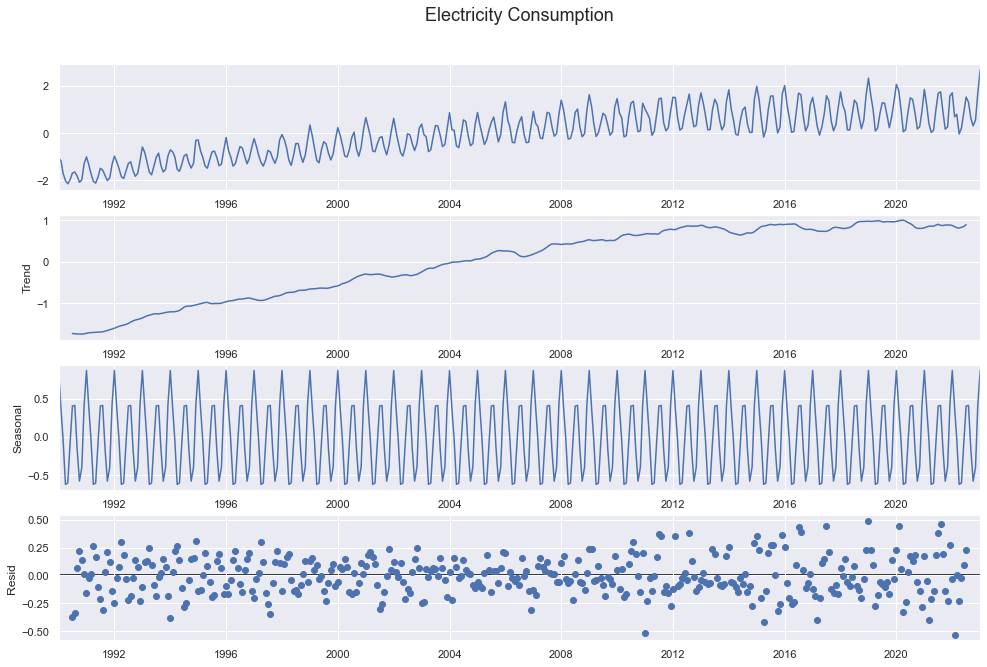

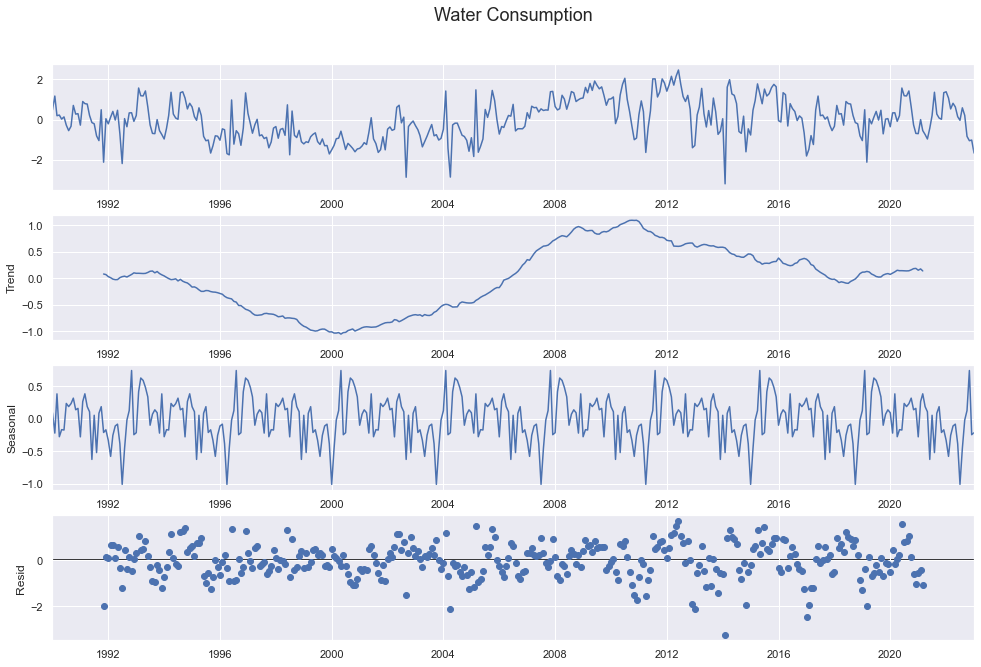

In [25]:
gas_consumption_seasonal_decompose = seasonal_decompose_plot(gas_consumption_series, "Gas Consumption", period=48)
electricity_consumption_seasonal_decompose = seasonal_decompose_plot(electricity_consumption_series, "Electricity Consumption", period=12)
water_consumption_seasonal_decompose = seasonal_decompose_plot(water_consumption_series, "Water Consumption", period=45)

### Statistical Tests for Stationarity

--------------------
#### Augmented Dickey-Fuller Test
Hypotheses:
<br>$H_0$: The data is non-stationary. 
<br>$H_A$: The data is stationary.
--------------------

#### Kwiatkowski Phillips Schmidt Shin Test
Hypotheses:
<br>$H_0$: The data is stationary.
<br>$H_A$: The data is not stationary.
--------------------


In [26]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def stationarity_tests(series, a=0.05):
    warnings.filterwarnings("ignore")
    

    # https://www.statology.org/dickey-fuller-test-python/
    # https://analyticsindiamag.com/how-to-make-a-time-series-stationary/
    # test whether the data is stationary or non-stationary using Augmented Dickey-Fuller Test and Kwiatkowski Phillips Schmidt Shin Test

#     print(f"Augmented Dickey-Fuller Test\nHypotheses:\n{'-'*20}\nH0: The data is non-stationary. \nHA: The data is stationary.\n{'-'*20}")

    adf_test = adfuller(series)

    (adf_test_statistic, adf_p_value) = adf_test[0: 2]
#     print(f"Test Statistics: {test_statistic}")
#     print(f"P-Value: {p_value}")
#     if p_value < 0.05:
#         print(f"{'-'*20}\nSince P-value < significance level of 0.05, we can reject the null hypothesis and conclude that the data is stationary.")
#     else:
#         print(f"{'-'*20}\nSince P-value > significance level of 0.05, we cannot reject the null hypothesis and thus conclude that the data is not stationary.")
    
#     print(f"\nKwiatkowski Phillips Schmidt Shin Test\nHypotheses:\n{'-'*20}\nH0: The data is stationary.\nHA: The data is not stationary.\n{'-'*20}")

    kpss_test = kpss(series, regression="ct")

    (kpss_test_statistic, kpss_p_value) = kpss_test[0: 2]
#     print(f"Test Statistics: {test_statistic}")
#     print(f"P-Value: {p_value}")
#     if p_value < 0.05:
#         print(f"{'-'*20}\nSince P-value < significance level of 0.05, we can reject the null hypothesis and conclude that the data is not stationary.")
#     else:
#         print(f"{'-'*20}\nSince P-value > significance level of 0.05, we cannot reject the null hypothesis and thus conclude that the data is stationary.")
 
    results_df = pd.DataFrame(columns=["Test Statistic", "P-Value", "Conclusion"])
    
    results_df["Test Statistic"] = [adf_test_statistic, kpss_test_statistic]
    results_df["P-Value"] = [adf_p_value, kpss_p_value]
    results_df["Conclusion"] = ["Stationary" if adf_p_value < a else "Non-Stationary", "Non-Stationary" if kpss_p_value < a else "Stationary"]
    
    results_df.index = ["Augmented Dickey-Fuller Test", "Kwiatkowski-Phillips-Schmidt-Shin-Test"]
    
    print(f"At {a} significance level:")
    
    return results_df
    
    
    # InterpolationWarning: The test statistic is outside of the range of p-values available in the
    # look-up table. The actual p-value is smaller than the p-value returned. <-- ***

**Cases**
1. Both tests conclude that the given series is stationary – The series is stationary
2. Both tests conclude that the given series is non-stationary – The series is non-stationary
3. ADF concludes non-stationary, and KPSS concludes stationary – The series is trend stationary. To make the series strictly stationary, the trend needs to be removed in this case. Then the detrended series is checked for stationarity.
4. ADF concludes stationary, and KPSS concludes non-stationary – The series is difference stationary. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity. <br>
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [27]:
print("Gas Consumption Series:")

stationarity_tests(gas_consumption_series)

Gas Consumption Series:
At 0.05 significance level:


Test Statistic   P-Value  \
Augmented Dickey-Fuller Test                 -3.418406  0.010347   
Kwiatkowski-Phillips-Schmidt-Shin-Test        0.296366  0.010000   

                                            Conclusion  
Augmented Dickey-Fuller Test                Stationary  
Kwiatkowski-Phillips-Schmidt-Shin-Test  Non-Stationary

In [28]:
print("Electricity Consumption Series:")

stationarity_tests(electricity_consumption_series)

Electricity Consumption Series:
At 0.05 significance level:


Test Statistic   P-Value  \
Augmented Dickey-Fuller Test                 -2.195499  0.207883   
Kwiatkowski-Phillips-Schmidt-Shin-Test        0.485181  0.010000   

                                            Conclusion  
Augmented Dickey-Fuller Test            Non-Stationary  
Kwiatkowski-Phillips-Schmidt-Shin-Test  Non-Stationary

In [29]:
print("Water Consumption Series:")

stationarity_tests(water_consumption_series)

Water Consumption Series:
At 0.05 significance level:


Test Statistic   P-Value  \
Augmented Dickey-Fuller Test                 -4.676428  0.000093   
Kwiatkowski-Phillips-Schmidt-Shin-Test        0.274685  0.010000   

                                            Conclusion  
Augmented Dickey-Fuller Test                Stationary  
Kwiatkowski-Phillips-Schmidt-Shin-Test  Non-Stationary

**Observation**
* Gas Consumption Series: falls under Case 4, differencing is needed to make the data strictly stationary
* Electricity Consumption Series: falls under Case 2
* Water Consumption Series: falls under Case 4, differencing is needed to make the data strictly stationary

## Differencing
The ARIMA family of time series models have a built in differencing $d$ component, where $d$ is the differencing order. <br>
https://people.duke.edu/~rnau/411arim2.htm

From the article:
* Rule 1: If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
* Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced. 
* Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest.


One of the methods to choose an appropriate differencing term is by looking at the Autocorrelation and Partial Autocorrelation Plots. <br>

Gas Consumption Series:

No differencing:


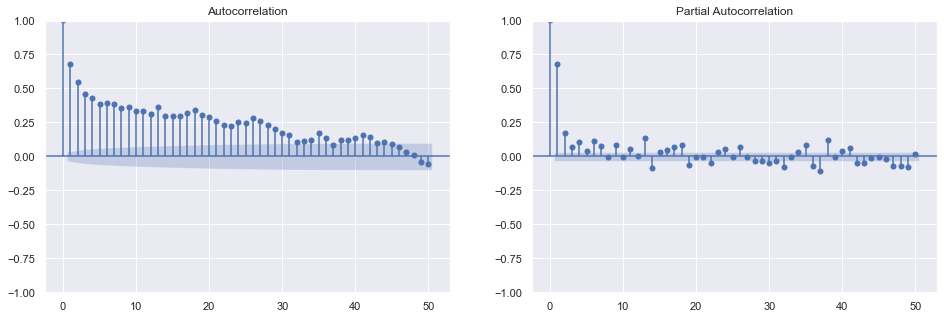

First order differencing:


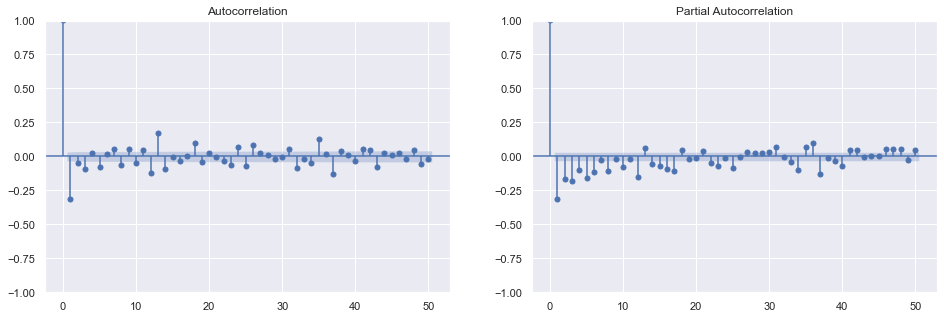

In [30]:
def differencing_acf_pacf_plots(series, plot_log=True, lags=50):

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))

    plot_acf(series, ax=axes[0], lags=lags, alpha=0.5, label="Default")
    plot_pacf(series, ax=axes[1], lags=lags, method='ywm', alpha=0.5, label="Default")
    
#     if plot_log:
#         plot_acf(np.log(series), ax=axes[0], lags=20, alpha=0.5, label="Log Transform")
#         plot_pacf(np.log(series), ax=axes[1], lags=20, method='ywm', alpha=0.5, label="Log Transform")
#         axes[0].legend(["Default", "Log Transform"])
#         axes[0].get_legend().legendHandles[0].set_color((0.2980392156862745, 0.4470588235294118, 0.6901960784313725))
#         axes[0].get_legend().legendHandles[1].set_color((0.8666666666666667, 0.5176470588235295, 0.3215686274509804))

#         axes[1].legend(["Default", "Log Transform"])
#         axes[1].get_legend().legendHandles[0].set_color((0.2980392156862745, 0.4470588235294118, 0.6901960784313725))
#         axes[1].get_legend().legendHandles[1].set_color((0.8666666666666667, 0.5176470588235295, 0.3215686274509804))

    plt.show()

print("Gas Consumption Series:\n")
    
print("No differencing:")
differencing_acf_pacf_plots(gas_consumption_series)

# x = np.log(gas_consumption_series)
x = gas_consumption_series
print("First order differencing:")
differencing_acf_pacf_plots(np.diff(x), plot_log=False)

**Observation** <br>
$d=1$ is the appropriate differencing term.

## Differencing
Another method to find the appropriate differencing term as well as the appropriate seasonal differencing term, $D$, is by evaluating the standard deviation of the resulting differenced series. The optimal differencing terms will result in the lowest standard deviation. This method also finds the optimal seasonal period if there is a seasonal differencing term.

In [31]:
print(f"Gas Consumption Series Differencing Orders: {find_best_diff_order(gas_consumption_series)}")
print(f"Electricity Consumption Series Differencing Orders: {find_best_diff_order(electricity_consumption_series)}")
print(f"Water Consumption Series Differencing Orders: {find_best_diff_order(water_consumption_series)}")

Gas Consumption Series Differencing Orders: ((1, 0), 2)
Electricity Consumption Series Differencing Orders: ((1, 1), 12)
Water Consumption Series Differencing Orders: ((1, 0), 2)


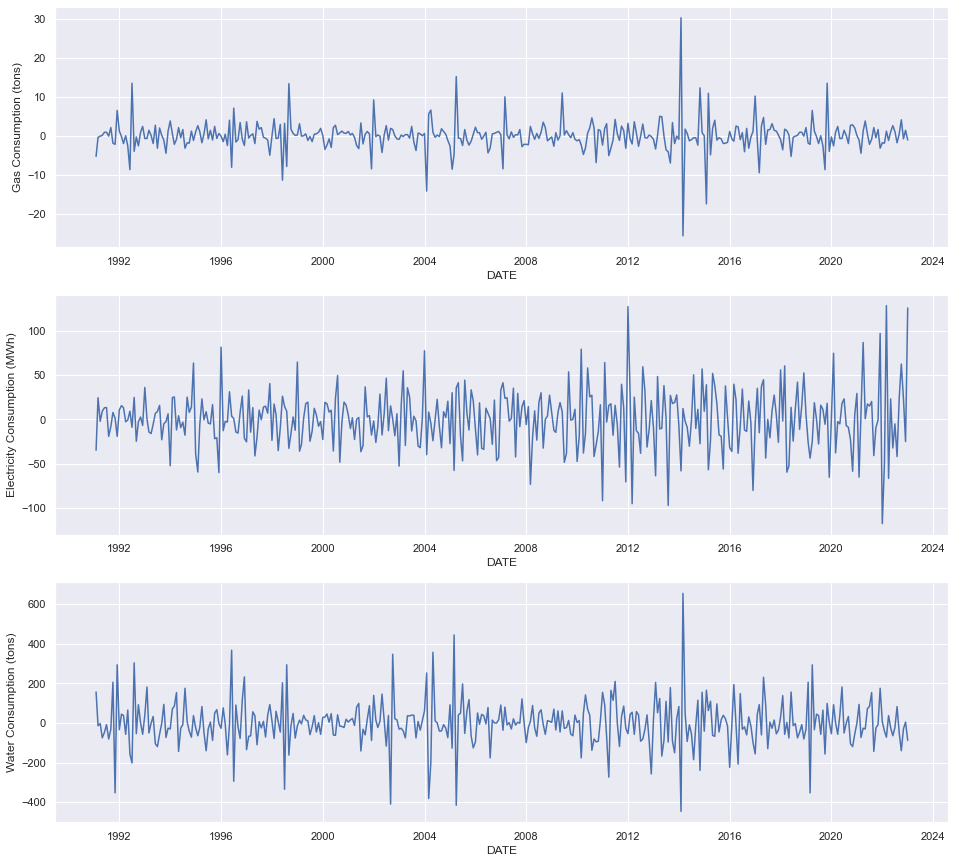

In [32]:
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(16, 15))

for i, col in enumerate(numeric_columns):
    sns.lineplot(data=differenced_eda_df.reset_index(), x="DATE", y=col, ax=axes[i])
plt.show()

In [33]:
print("Gas Consumption Series:")

stationarity_tests(k_diff(gas_consumption_series, 1, 0))

Gas Consumption Series:
At 0.05 significance level:


Test Statistic       P-Value  \
Augmented Dickey-Fuller Test                 -7.811089  7.066742e-12   
Kwiatkowski-Phillips-Schmidt-Shin-Test        0.089844  1.000000e-01   

                                        Conclusion  
Augmented Dickey-Fuller Test            Stationary  
Kwiatkowski-Phillips-Schmidt-Shin-Test  Stationary

In [34]:
print("Electricity Consumption Series:")

stationarity_tests(k_diff(electricity_consumption_series, 1, 1, seasonal_period=12))

Electricity Consumption Series:
At 0.05 significance level:


Test Statistic       P-Value  \
Augmented Dickey-Fuller Test                 -8.019366  2.096457e-12   
Kwiatkowski-Phillips-Schmidt-Shin-Test        0.048818  1.000000e-01   

                                        Conclusion  
Augmented Dickey-Fuller Test            Stationary  
Kwiatkowski-Phillips-Schmidt-Shin-Test  Stationary

In [35]:
print("Water Consumption Series:")

stationarity_tests(k_diff(water_consumption_series, 1, 0))

Water Consumption Series:
At 0.05 significance level:


Test Statistic       P-Value  \
Augmented Dickey-Fuller Test                 -9.062086  4.534434e-15   
Kwiatkowski-Phillips-Schmidt-Shin-Test        0.095551  1.000000e-01   

                                        Conclusion  
Augmented Dickey-Fuller Test            Stationary  
Kwiatkowski-Phillips-Schmidt-Shin-Test  Stationary

## Model Evaluation

One of the goals set out by the assignment is ```2. Tune the hyperparameters of the time series model to maximize the accuracy
for training data and testing data prediction.``` Thus, I will select my evaluation metrics accordingly.

**Metrics**:

1. AIC (Akaike Information Criterion)
    * Formula: $\text{AIC} = 2k - 2\ln(\hat{L})$
    * Legend:
        * $k$: Number of estimated parameters in the model.
        * $\hat{L}$: Maximum likelihood estimation of the model.
        
        <br>
        
2. RMSE (Root Mean Square Error)
    * Formula: $\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$
    
3. MAE (Mean Absolute Error)
    * Formula: $\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$


* **AIC** scores models based on fit and complexity (number of parameters). It is useful for model selection and preventing overfitting but does not account for forecast accuracy.
* **RMSE** and **MAE** measure the accuracy of forecasts, indicating how well the model performs in terms of predicting actual values, which is the goal of this task. I evaluate both of these metrics since the difference between the value of RMSE and MAE can indicate whether there are more or less outliers in the predictions.

In [25]:
from tqdm.notebook import tqdm

def walkforward_validation(model, params, data, rolling=True, gap=2, step=2, forecast_period=6, validation_size=0.1, flatten=True, return_train=False, return_coefficients=False, verbose=True
                          ):
    """ 
    walk-forward validation v2
    model: function that returns a class with the fit() method which returns class with forecast() method
    params: hyperparameters for model()
    data: time series to fit the model on
    rolling: whether to use rolling or expanding window
    forecast_period: number of months to predict using each set of training data by
    step: number of months to increase each consecutive set of training data by
    validation_size: fraction of dataset to use for validating predictions
    flatten: return the forecasts and predictions as 1d array or 2d array of size n_train_sets, forecast_period
    return_coefficients: whether to return the ar, ma, sar, sma coefficients of the model (disable for non-arima models)
    """

    forecast_period += gap
# model = statespace
# forecast_period = 20
# 6-month forecasting window for eg.
# step = 1
# data = gas_consumption_series
# validation_size=0.2
    constant_train_data = data[:round(len(data)*(1-validation_size))]
    train_data = data[round(len(data)*(1-validation_size)):]
    train_sets = [constant_train_data]
#     print(constant_train_data)
    for i in range(step, len(train_data)-forecast_period-step, step):
        train_sets.append(constant_train_data.append(train_data[:i])[i if rolling else 0:])
#         print(train_sets[-1)
#     print(len(train_sets))
    validation_sets = []
    for i in range(0, len(train_data)-forecast_period, step):
        validation_sets.append(train_data[i:i+forecast_period])

    forecast_sets = []
    
    if return_coefficients:
        model_parameters = []
    if return_train:
        in_sample_sets = []
    
    for i in tqdm(range(len(train_sets))) if verbose else range(len(train_sets)):
    #         print(validation_sets[i])
        tsa_model = model(train_sets[i], params)
#         print(train_sets[i].index)
#         print(len(train_sets[i]), len(train_sets[i]))
        tsa_model_fit = tsa_model.fit()
        forecast = tsa_model_fit.predict(start=len(train_sets[i]), end=len(train_sets[i])+forecast_period-1)
        forecast_sets.append(forecast)
        
        if return_train:
            in_sample = tsa_model_fit.predict()
            in_sample_sets.append(in_sample)
        
        if return_coefficients:
            model_parameters.append({})
            model_parameters[i]["ar"] = tsa_model_fit.polynomial_ar
            model_parameters[i]["ma"] = tsa_model_fit.polynomial_ma
            model_parameters[i]["sar"] = tsa_model_fit.polynomial_seasonal_ar
            model_parameters[i]["sma"] = tsa_model_fit.polynomial_seasonal_ma
#         print(forecast)

    returns = []
    
    if flatten:
        validations = validation_sets[0]
        forecasts = forecast_sets[0]
        for i in range(1, len(forecast_sets)):
            validations = validations.append(validation_sets[i])
            forecasts = forecasts.append(forecast_sets[i])
        returns.append(validations)
        returns.append(forecasts)
            
        if return_train:
            trains = train_sets[0]
            in_samples = in_sample_sets[0]
            for i in range(1, len(in_sample_sets)):
                trains = trains.append(train_sets[i])
                in_samples = in_samples.append(in_sample_sets[i])
            returns.append(trains)
            returns.append(in_samples)
    else:
        returns.append(validation_sets)
        returns.append(forecast_sets)
        
        if return_train:
            returns.append(train_sets)
            returns.append(in_sample_sets)
        
    if return_coefficients:
        returns.append(model_parameters)
    
#     print(train_sets[0])
#     print(in_sample_sets[0])
    return returns

# def holt(endog, params):
#     return statsmodels.tsa.holtwinters.Holt(endog, **params)

def hwes(endog, params):
    return statsmodels.tsa.holtwinters.ExponentialSmoothing(endog, **params)

def arima(endog, params):
    return sm.tsa.arima.ARIMA(endog, **params)

def sarimax(endog, params):
    return sm.tsa.statespace.SARIMAX(endog, **params)

def statespace(endog, params):
    return statsmodels.tsa.statespace.structural.UnobservedComponents(endog, **params)

def varmax(endog, params):
    return statsmodels.tsa.statespace.varmax.VARMAX(endog, **params)

def aic_score(model, params, series):
#     print(params)
    tsa_model = model(series, params)
    return -tsa_model.fit().aic

import copy

def arima_(endog, params):
    params = copy.deepcopy(params)
    params["order"] = (params.pop("p"), params.pop("d"), params.pop("q"))
    params["seasonal_order"] = (params.pop("P"), params.pop("D"), params.pop("Q"), params.pop("M"))
    return arima(endog, params)

def sarimax_(endog, params):
    params = copy.deepcopy(params)
    params["order"] = (params.pop("p"), params.pop("d"), params.pop("q"))
    params["seasonal_order"] = (params.pop("P"), params.pop("D"), params.pop("Q"), params.pop("M"))
    return sarimax(endog, params)

def varmax_(endog, params):
    params = copy.deepcopy(params)
    params["order"] = (params.pop("p"), params.pop("q"))
    if params["order"] == (0, 0):
        params["order"] = (1, 0)
    return varmax(endog, params)

## Determining AR and MA terms

In [27]:
def plot_acf_pacf(series, d, D, seasonal_period=12, plot_seasonal=False):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 10))
    
    lags = np.arange(seasonal_period, seasonal_period*8, seasonal_period) if plot_seasonal else 50

    plot_acf(k_diff(series, d, D, seasonal_period=seasonal_period), ax=axes[0], lags=lags, alpha=0.5, label="Default")
    plot_pacf(k_diff(series, d, D, seasonal_period=seasonal_period), ax=axes[1], lags=lags, method='ywm', alpha=0.5, label="Default")

    plt.show()

### Gas Consumption Series

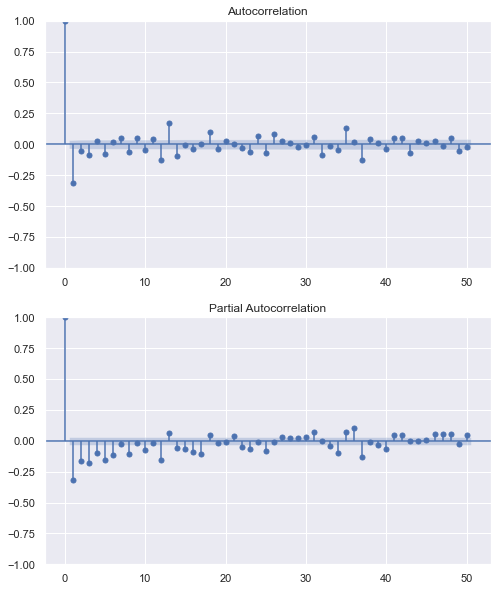

In [38]:
plot_acf_pacf(gas_consumption_series, 1, 0)

**Observations:**
* ACF somewhat cuts off at lag-1 so I will add an $MA$ term
* There isn't an obvious seasonal period from the original data so I will use only an ARIMA model instead of SARIMA first.

In [28]:
def evaluation_descriptive(series, model, params, transformer, return_scores=False, plot_arima=True, is_hwes=False, return_coefficients=True, **kwargs):

    temp_arima = model(series, params).fit()
    print("AIC: ", temp_arima.aic)

    if return_coefficients:
        wf_valid, wf_pred, wf_train, wf_in_sample, coefs = walkforward_validation(model, params, series, validation_size=0.1, return_train=True, return_coefficients=True)
    else:
        wf_valid, wf_pred, wf_train, wf_in_sample = walkforward_validation(model, params, series, validation_size=0.1, return_train=True, return_coefficients=False)

    scores = pd.DataFrame()
    
    scores["mae_test"] = [mean_absolute_error(reverse_transform_series(wf_valid, transformer), reverse_transform_series(wf_pred, transformer))]
    scores["mae_train"] = [mean_absolute_error(reverse_transform_series(wf_train, transformer), reverse_transform_series(wf_in_sample, transformer))] if not is_hwes else 0 
    scores["rmse_test"] = [mean_squared_error(reverse_transform_series(wf_valid, transformer), reverse_transform_series(wf_pred, transformer), squared=False)]
    scores["rmse_train"] = [mean_squared_error(reverse_transform_series(wf_train, transformer), reverse_transform_series(wf_in_sample, transformer), squared=False)] if not is_hwes else 0
    
    print("MAE (test): ", scores["mae_test"][0])
    print("MAE (train): ", scores["mae_train"][0])
    print("RMSE (test): ", scores["rmse_test"][0])
    print("RMSE (train): ", scores["rmse_train"][0])

    if plot_arima:
        print("AR Coefficients: ", temp_arima.polynomial_ar)
        print("MA Coefficients: ", temp_arima.polynomial_ma)
        print("SAR Coefficients: ", temp_arima.polynomial_seasonal_ar)
        print("SMA Coefficients: ", temp_arima.polynomial_seasonal_ma)
        
        plot_acf_pacf(temp_arima.resid, 0, 0, **kwargs)
    
    if return_scores:
        return scores

AIC:  886.1087436643672


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  2.4073503629944932
MAE (train):  2.485491324638523
RMSE (test):  3.118468218704852
RMSE (train):  3.7108166291410996
AR Coefficients:  [1.]
MA Coefficients:  [ 1.         -0.53580746]
SAR Coefficients:  [1.]
SMA Coefficients:  [1.]


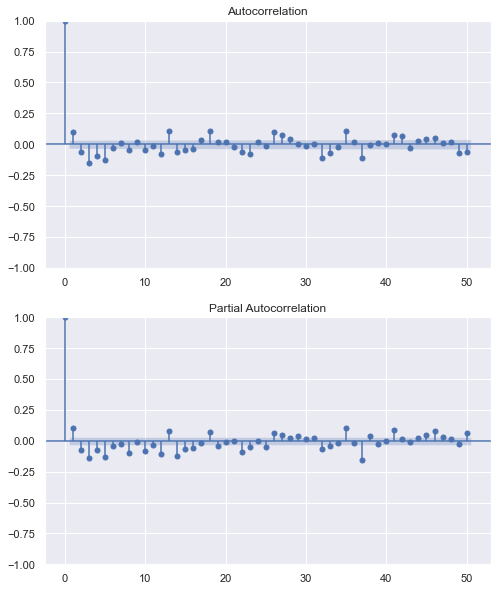

In [40]:
evaluation_descriptive(gas_consumption_series, arima, {"order": (0, 1, 1)}, gas_pt)

Based on rule 13 [from this article](https://people.duke.edu/~rnau/arimrule.htm), at lag-12 for example the autocorrelation is negative thus I will add an $SMA(1)$ term. <br>
Since I am unsure of the seasonal period, I will implement a function to try different seasonal periods with their corresponding SAR or SMA term based on the sign at the lag.

In [41]:
n_seasonal_periods_range =  range(4, 40)
scores = []

# validation_gas_consumption_series = gas_consumption_series.iloc[:round(len(gas_consumption_series)*0.8)]

for seasonal_period in tqdm(n_seasonal_periods_range):
    autocorr = acf(k_diff(gas_consumption_series, 1, 0), nlags=seasonal_period)[-1]
    if autocorr > 0:
        P = 1
        Q = 0
    elif autocorr < 0:
        P = 0
        Q = 1
    else:
        P = 0
        Q = 0
    params = {"order": (0, 1, 1), "seasonal_order": (P, 0, Q, seasonal_period)}
    scores.append(mean_squared_error(*walkforward_validation(arima, params, gas_consumption_series), squared=False))
    print(params, scores[-1])
    
print(n_seasonal_periods_range[np.argmin(scores)])

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'order': (0, 1, 1), 'seasonal_order': (1, 0, 0, 4)} 0.6236267586521473


  0%|          | 0/15 [00:00<?, ?it/s]

{'order': (0, 1, 1), 'seasonal_order': (0, 0, 1, 5)} 0.6320317371174942


  0%|          | 0/15 [00:00<?, ?it/s]

{'order': (0, 1, 1), 'seasonal_order': (1, 0, 0, 6)} 0.6200251619663459


  0%|          | 0/15 [00:00<?, ?it/s]

{'order': (0, 1, 1), 'seasonal_order': (1, 0, 0, 7)} 0.6189338801352061


  0%|          | 0/15 [00:00<?, ?it/s]

{'order': (0, 1, 1), 'seasonal_order': (0, 0, 1, 8)} 0.6154111565252569


  0%|          | 0/15 [00:00<?, ?it/s]

{'order': (0, 1, 1), 'seasonal_order': (1, 0, 0, 9)} 0.6222808581711753


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [55]:
pd.DataFrame([{"period": n_seasonal_periods_range[i], "score": score} for i, score in enumerate(scores)]).sort_values("score").set_index("period").head(5)

score
period          
14      0.601745
18      0.602074
15      0.605919
32      0.609752
16      0.610036

* The best performing seasonal periods are 14 and 18.

AIC:  886.5067709299888


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  2.3482158739390453
MAE (train):  2.485459592488665
RMSE (test):  3.0278454704894426
RMSE (train):  3.704155770218337
AR Coefficients:  [1.]
MA Coefficients:  [ 1.         -0.53415466]
SAR Coefficients:  [1.]
SMA Coefficients:  [ 1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        -0.0610321]


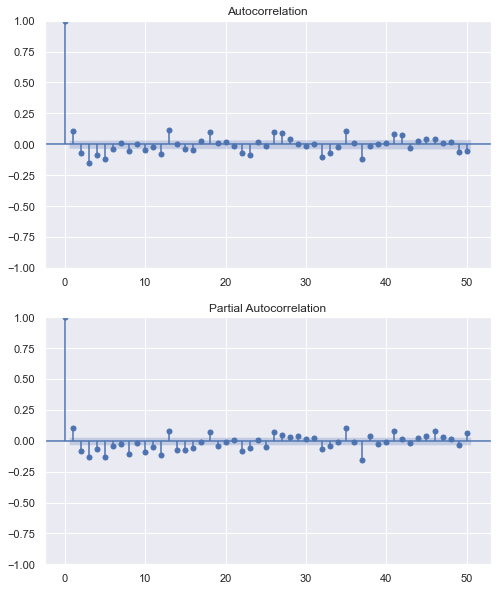

In [68]:
tsa_scores = {}
tsa_scores["gas"] = evaluation_descriptive(gas_consumption_series, arima, {"order": (0, 1, 1), "seasonal_order": (0, 0, 1, 14)}, gas_pt, return_scores=True)
# arima_scores["gas"].index[-1] = "base"

In [132]:
from pmdarima.arima import auto_arima
auto_mod = auto_arima(gas_consumption_series, max_q=10, max_Q=10, m=14, method='lbfgs', with_intercept=True, seasonal=True, information_criterion="aic", random=True, n_fits=30, max_order=20, maxiter=200, trace=True, n_jobs=-1)
# res = mod.fit(disp=False) end_p=4, start_q=0, end_q=4, start_P=0, end_P=3, start_Q=0, end_Q=3,
print(auto_mod.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[14] intercept   : AIC=864.689, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[14] intercept   : AIC=950.962, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[14] intercept   : AIC=912.402, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[14] intercept   : AIC=888.325, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[14]             : AIC=948.990, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[14] intercept   : AIC=862.837, Time=0.80 sec
 ARIMA(2,1,2)(0,0,0)[14] intercept   : AIC=862.603, Time=0.43 sec
 ARIMA(2,1,2)(1,0,0)[14] intercept   : AIC=862.740, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[14] intercept   : AIC=861.575, Time=0.20 sec
 ARIMA(1,1,2)(1,0,0)[14] intercept   : AIC=861.572, Time=0.48 sec
 ARIMA(1,1,2)(2,0,0)[14] intercept   : AIC=863.403, Time=1.23 sec
 ARIMA(1,1,2)(1,0,1)[14] intercept   : AIC=863.510, Time=1.13 sec
 ARIMA(1,1,2)(0,0,1)[14] intercept   : AIC=861.684, Time=0.65 sec
 ARIMA(1,1,2)(2,0,1)[14] intercept   : AIC=864.164, Time=3.09 sec
 ARIMA(0,1,2)(1,0,0)[14] intercep

AIC:  858.7918310627217


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  2.3719863817062663
MAE (train):  2.3988763178552803
RMSE (test):  3.0323692611385846
RMSE (train):  3.5749514923420502
AR Coefficients:  [ 1.         -0.42677443]
MA Coefficients:  [ 1.         -0.89298294]
SAR Coefficients:  [1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.07903627]
SMA Coefficients:  [1.]


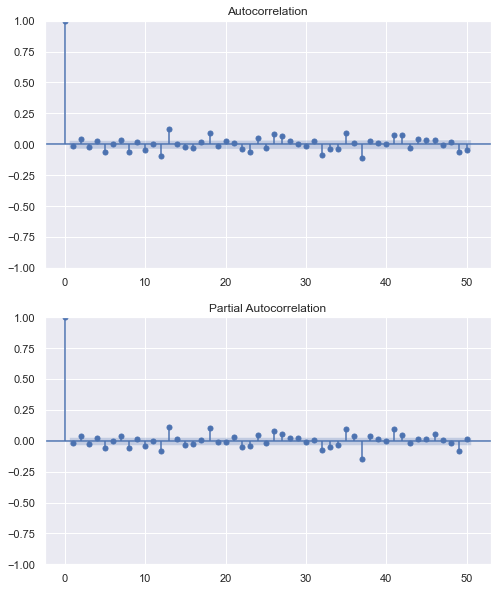

In [69]:
tsa_scores["gas"] = tsa_scores["gas"].append(evaluation_descriptive(gas_consumption_series, arima, {"order": (1, 1, 1), "seasonal_order": (1, 0, 0, 14)}, gas_pt, return_scores=True))
# arima_scores["gas"].index[-1] = "auto_arima"

AIC and RMSE measures do not always agree on the best model parameters. The focus of the time series analysis task is to maximise accuracy which AIC does not do, thus Auto ARIMA may not be the best method.

### Electricity Consumption Series

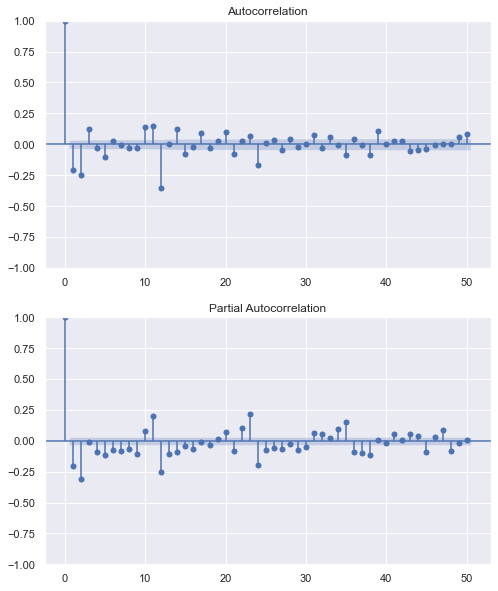

In [44]:
plot_acf_pacf(electricity_consumption_series, 1, 1)

**Observations:**
* Sharp cut off in at lag-2 in both ACF and PACF plots thus I will add both an $AR$ and $MA$ term.

AIC:  -169.60368040488044


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  33.4891156240216
MAE (train):  22.746346433399196
RMSE (test):  44.642696955118026
RMSE (train):  32.492074822577884
AR Coefficients:  [ 1.         -0.52718763]
MA Coefficients:  [ 1.         -0.99145635]
SAR Coefficients:  [1.]
SMA Coefficients:  [1.]


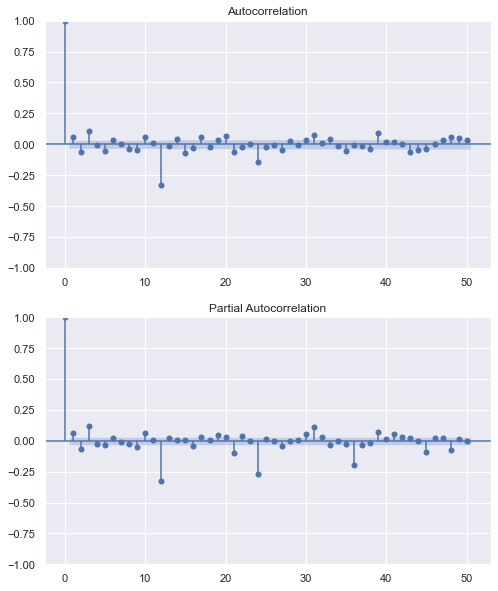

In [50]:
# plot the residuals at lags that are multiples of 12
evaluation_descriptive(electricity_consumption_series, arima, {"order": (1, 1, 1), "seasonal_order": (0, 1, 0, 12)}, electricity_pt)

Plotting ACF and PACF only at multiples of the seasonal period. (eg. 12, 24, 36, ...)

AIC:  -169.60368040488044


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  33.4891156240216
MAE (train):  22.746346433399196
RMSE (test):  44.642696955118026
RMSE (train):  32.492074822577884
AR Coefficients:  [ 1.         -0.52718763]
MA Coefficients:  [ 1.         -0.99145635]
SAR Coefficients:  [1.]
SMA Coefficients:  [1.]


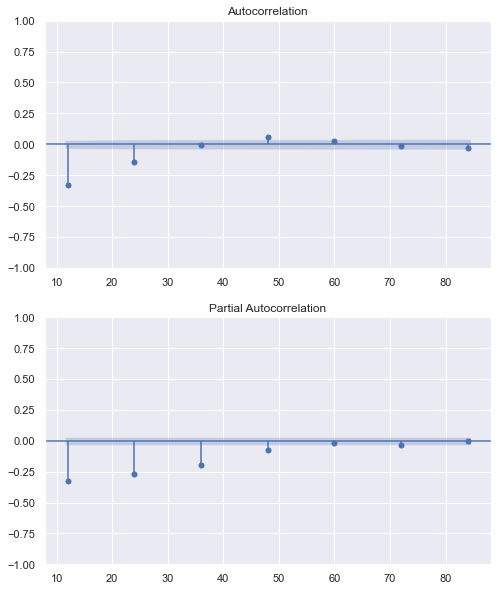

In [51]:
# plot the residuals at lags that are multiples of 12
evaluation_descriptive(electricity_consumption_series, arima, {"order": (1, 1, 1), "seasonal_order": (0, 1, 0, 12)}, electricity_pt, plot_seasonal=True)

**Observations:**
* There is a more significant cut off in the ACF plot than the PACF plot. I will add either a $SMA(2)$ or $SMA(3)$ term to the model.

AIC:  -303.18467746946453


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  29.456330134631152
MAE (train):  19.834452497403294
RMSE (test):  38.18113492205217
RMSE (train):  28.992363420809962
AR Coefficients:  [ 1.         -0.52514635]
MA Coefficients:  [ 1.         -0.95647794]
SAR Coefficients:  [1.]
SMA Coefficients:  [ 1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.69978677  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.05553461]


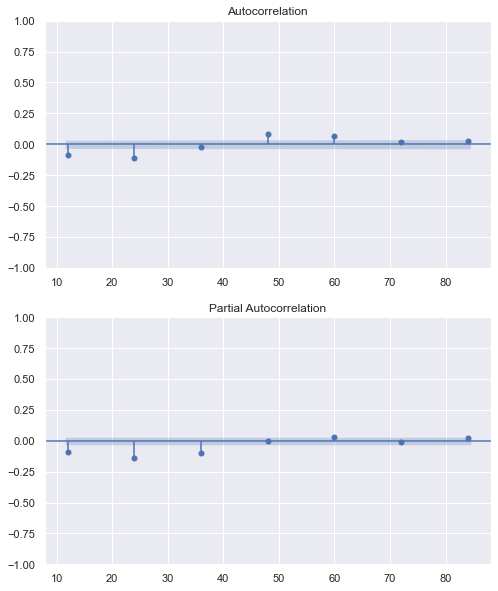

In [47]:
evaluation_descriptive(electricity_consumption_series, arima, {"order": (1, 1, 1), "seasonal_order": (0, 1, 2, 12)}, electricity_pt, plot_seasonal=True)

More $SMA$ terms are necessary.

AIC:  -320.3809500915536


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  27.227980886830885
MAE (train):  19.465739099105104
RMSE (test):  34.91681622194248
RMSE (train):  28.718052172107623
AR Coefficients:  [ 1.         -0.49574718]
MA Coefficients:  [ 1.         -0.95205934]
SAR Coefficients:  [1.]
SMA Coefficients:  [ 1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.73616726  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.20506358  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.16524981  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.10777838]


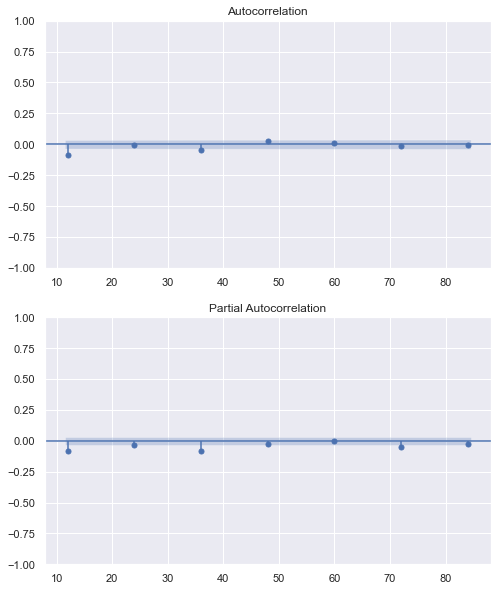

In [70]:
tsa_scores["electricity"] = evaluation_descriptive(electricity_consumption_series, arima, {"order": (1, 1, 1), "seasonal_order": (0, 1, 4, 12)}, electricity_pt, plot_seasonal=True, return_scores=True)
# arima_scores["electricity"].index[-1] = "base"

In [87]:
from pmdarima.arima import auto_arima
auto_mod = auto_arima(electricity_consumption_series, max_q=10, max_Q=10, m=12, d=1, D=1, method='lbfgs', with_intercept=True, seasonal=True, information_criterion="aic", random=True, n_fits=30, max_order=20, maxiter=200, trace=True, n_jobs=-1)
# res = mod.fit(disp=False) end_p=4, start_q=0, end_q=4, start_P=0, end_P=3, start_Q=0, end_Q=3,
print(auto_mod.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12] intercept   : AIC=-300.793, Time=8.69 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-79.096, Time=0.37 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=-148.877, Time=1.25 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-252.102, Time=1.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-81.049, Time=0.15 sec
 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=-304.183, Time=7.22 sec
 ARIMA(2,1,2)(0,1,0)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(2,1,2)(0,1,2)[12] intercept   : AIC=inf, Time=10.46 sec
 ARIMA(2,1,2)(1,1,0)[12] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(2,1,2)(1,1,2)[12] intercept   : AIC=-303.878, Time=18.35 sec
 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=-307.153, Time=5.82 sec
 ARIMA(1,1,2)(0,1,0)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(1,1,2)(1,1,1)[12] intercept   : AIC=-305.753, Time=8.02 sec
 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=inf, Time=12.45 sec
 ARIMA(1,1,2)(1,1,0)[12] intercept   : AIC=

the Auto ARIMA results agree with my manual term selection.

### Water Consumption Series

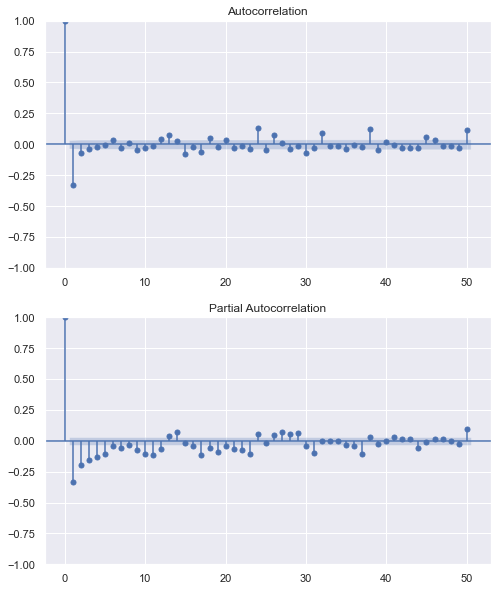

In [52]:
plot_acf_pacf(water_consumption_series, 1, 0)

**Observations:**
* Lag-1 autocorrelation is negative and cut off in ACF lag-1, so possibly an $MA(1)$ or $MA(2)$ model

AIC:  932.086941951505


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  106.51578990011652
MAE (train):  77.18378594048595
RMSE (test):  130.31467060265973
RMSE (train):  106.46004568340469
AR Coefficients:  [1.]
MA Coefficients:  [ 1.         -0.55807993]
SAR Coefficients:  [1.]
SMA Coefficients:  [1.]


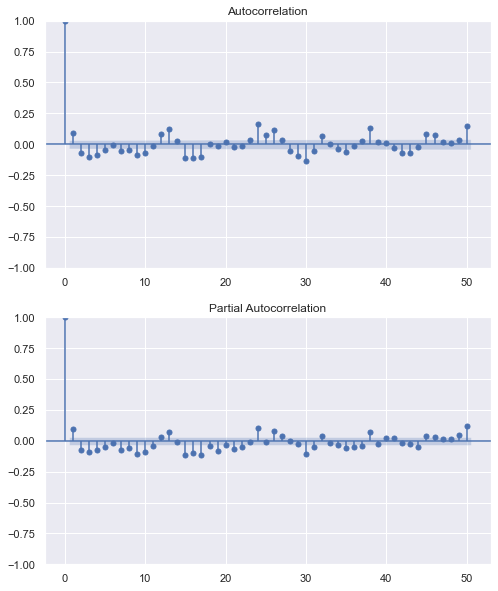

In [56]:
evaluation_descriptive(water_consumption_series, arima, {"order": (0, 1, 1)}, water_pt)

I will add both an $AR$ and $MA$ term.

AIC:  907.6587347533602


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  87.29470570320926
MAE (train):  74.6029493326991
RMSE (test):  108.12251665263804
RMSE (train):  102.87341155545565
AR Coefficients:  [ 1.         -0.62613702]
MA Coefficients:  [ 1.         -1.14845261  0.19205358]
SAR Coefficients:  [1.]
SMA Coefficients:  [1.]


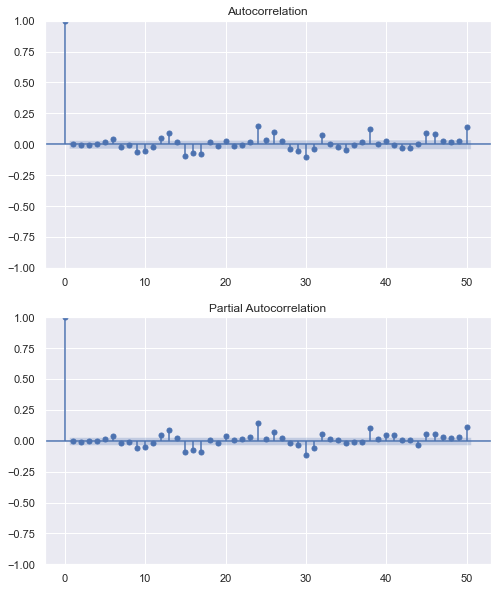

In [55]:
evaluation_descriptive(water_consumption_series, arima, {"order": (1, 1, 2)}, water_pt)

In [143]:
n_seasonal_periods_range =  range(3, 40)
scores = []
mean_sar_coef = []
mean_sma_coef = []

for seasonal_period in tqdm(n_seasonal_periods_range):
    autocorr = acf(k_diff(water_consumption_series, 1, 0), nlags=seasonal_period)[-1]
    if autocorr > 0:
        P = 1
        Q = 0
    elif autocorr < 0:
        P = 0
        Q = 1
    else:
        P = 0
        Q = 0
    params = {"order": (1, 1, 2), "seasonal_order": (P, 0, Q, seasonal_period)}
    pred, val, coef = walkforward_validation(arima, params, gas_consumption_series, return_coefficients=True)
    mean_sar_coef.append(np.mean([c["sar"][-1] for c in coef]))
    mean_sma_coef.append(np.mean([c["sma"][-1] for c in coef]))
    scores.append(mean_squared_error(pred, val, squared=False))
    print(params, scores[-1])
    
print(n_seasonal_periods_range[np.argmin(scores)])
print(n_seasonal_periods_range[np.argmax(mean_sar_coef)])
print(n_seasonal_periods_range[np.argmax(mean_sma_coef)])

  0%|          | 0/36 [00:00<?, ?it/s]

{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 4)} 0.618835772867652
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 5)} 0.6240793091480292
{'order': (1, 1, 2), 'seasonal_order': (1, 0, 0, 6)} 0.6192490460073472
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 7)} 0.6188499602553738
{'order': (1, 1, 2), 'seasonal_order': (1, 0, 0, 8)} 0.6175691310469316
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 9)} 0.6224304268155019
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 10)} 0.6166222615595816
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 11)} 0.6191014127418283
{'order': (1, 1, 2), 'seasonal_order': (1, 0, 0, 12)} 0.6155723618197976
{'order': (1, 1, 2), 'seasonal_order': (1, 0, 0, 13)} 0.6402416655300803
{'order': (1, 1, 2), 'seasonal_order': (1, 0, 0, 14)} 0.6043501310457127
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 15)} 0.6146356749275629
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 16)} 0.6120201650374031
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 1, 17)} 0.61

In [144]:
pd.DataFrame([{"period": n_seasonal_periods_range[i], "score": score} for i, score in enumerate(scores)]).sort_values("score").set_index("period").head(5)

score
period          
35      0.598308
14      0.604350
18      0.604543
39      0.610254
24      0.611773

**Observations:**
* The best performing seasonal periods are 35, 14, and 18. 

AIC:  909.0131294945818


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  86.98771581519591
MAE (train):  74.45884464101294
RMSE (test):  107.62458729947062
RMSE (train):  102.81327087160079
AR Coefficients:  [ 1.         -0.62926757]
MA Coefficients:  [ 1.         -1.15259135  0.19697747]
SAR Coefficients:  [1.]
SMA Coefficients:  [ 1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.04065716]


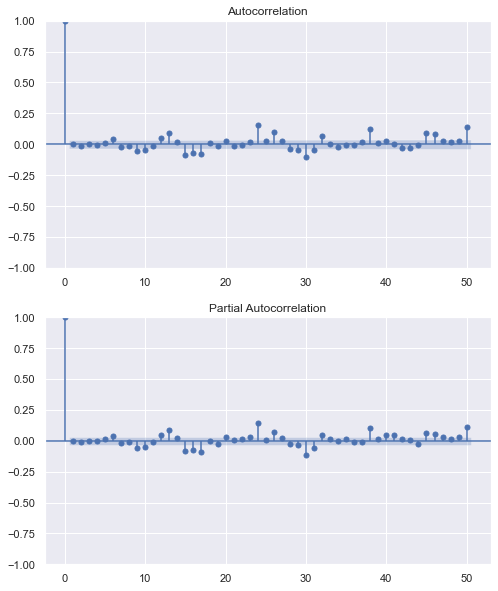

In [71]:
tsa_scores["water"] = evaluation_descriptive(water_consumption_series, arima, {"order": (1, 1, 2), "seasonal_order": (0, 0, 1, 35)}, water_pt, return_scores=True)

* Including a seasonal term doesn't seem to improve performance by much.

In [146]:
from pmdarima.arima import auto_arima
auto_mod = auto_arima(water_consumption_series, max_q=10, max_Q=10, m=12, d=1, D=0, method='lbfgs', with_intercept=True, seasonal=True, information_criterion="aic", random=True, n_fits=30, max_order=20, maxiter=200, trace=True, n_jobs=-1)
# res = mod.fit(disp=False) end_p=4, start_q=0, end_q=4, start_P=0, end_P=3, start_Q=0, end_Q=3,
print(auto_mod.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=909.938, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1006.451, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=962.636, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=933.973, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1004.467, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=912.584, Time=1.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=912.245, Time=1.09 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=905.670, Time=6.69 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=903.804, Time=3.20 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=902.742, Time=1.86 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=910.406, Time=0.60 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=904.562, Time=3.18 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=908.499, Time=1.93 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=912.927, Time=0.54 sec
 ARIMA(1,1,1)(2,0,0)[12] interc

AIC:  900.7667295535439


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  82.21341311552578
MAE (train):  73.32313321518177
RMSE (test):  102.17688106222886
RMSE (train):  101.6572975288717
AR Coefficients:  [ 1.         -0.67243027]
MA Coefficients:  [ 1.         -1.21312822  0.24459481]
SAR Coefficients:  [ 1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.05470304  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.15940979]
SMA Coefficients:  [1.]


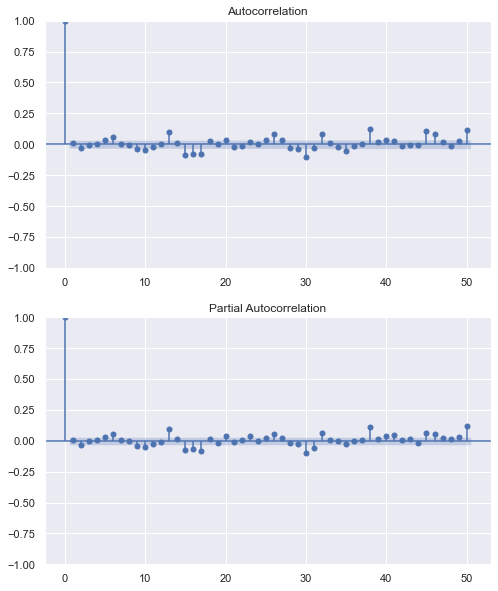

In [72]:
tsa_scores["water"] = tsa_scores["water"].append(evaluation_descriptive(water_consumption_series, arima, {"order": (1, 1, 2), "seasonal_order": (2, 0, 0, 12)}, water_pt, return_scores=True))
# arima_scores["water"].index[-1] = "auto_arima"

In [84]:
def plot_model_params(series, model, params, transformer, title="", past_length=36, test_length=12, forecast_length=12, is_hwes=False, plot_conf_int=True, **kwargs):
    if not is_hwes:
        forecast_wrapper = model(series[:-test_length], params).fit().get_prediction(start=len(series)-past_length, end=len(series)+forecast_length)
        forecasted_series = reverse_transform_series(forecast_wrapper.predicted_mean, transformer)
        if plot_conf_int:
            lower_conf_int = reverse_transform_series(forecast_wrapper.conf_int().loc[series.index[-test_length]:, "lower y"], transformer)
            upper_conf_int = reverse_transform_series(forecast_wrapper.conf_int().loc[series.index[-test_length]:, "upper y"], transformer)
    else: 
        forecasted_series = reverse_transform_series(model(series[:-test_length], params).fit().predict(start=len(series)-past_length, end=len(series)+forecast_length), transformer)
    # validate_plot(gas_consumption_series, arima, , gas_pt)
    # {'order': (3, 1, 0), 'seasonal_order': (3, 0, 2, 24)}
    # (validation, transformer)
    # forecasted_series = first_electricity_consumption_series.append(forecast_wrapper.predicted_mean).cumsum()
    
    
    sns.set(style="darkgrid")
    plt.figure(**kwargs)
    sns.lineplot(data=reverse_transform_series(series, transformer)[-past_length:], linestyle='solid', label="Train")
    sns.lineplot(data=forecasted_series, linestyle='solid', alpha=0.7, label="Predicted")

    test = reverse_transform_series(series, transformer)[-test_length: ]

    predict = forecasted_series.loc[test.index[0]: test.index[-1]]
    
    print(f"MAE (test): {mean_absolute_error(test, predict)}")
    print(f"RMSE (test): {mean_squared_error(test, predict, squared=False)}")

    sns.lineplot(data=test, linestyle='solid', label="Test")
    
    if plot_conf_int:
        plt.fill_between(lower_conf_int.index, lower_conf_int, upper_conf_int, alpha=0.3, label="Confidence Interval")
        
    if title != "":
        plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    # plt.legend(['Actual', 'Confidence Interval', 'Predicted'])

    plt.axvline(x=series.index[-test_length], color='k', linestyle='--', alpha=0.1)
    plt.axvline(x=series.index[-1], color='k', linestyle='--', alpha=0.1)
    plt.legend(loc="upper left")
    plt.show()

## Initial Tuning Results of SARIMA

MAE (test): 2.094432522117321
RMSE (test): 2.4842377523333896


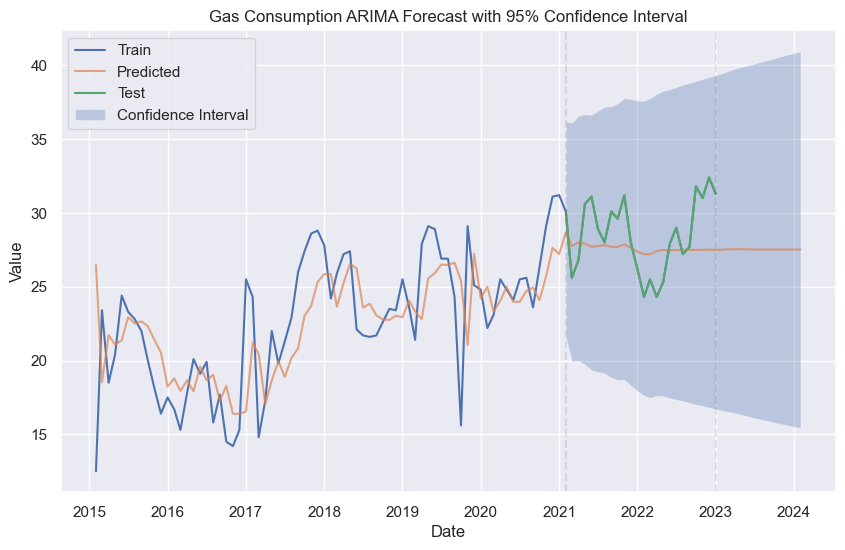

MAE (test): 27.7254377559711
RMSE (test): 38.56942852276296


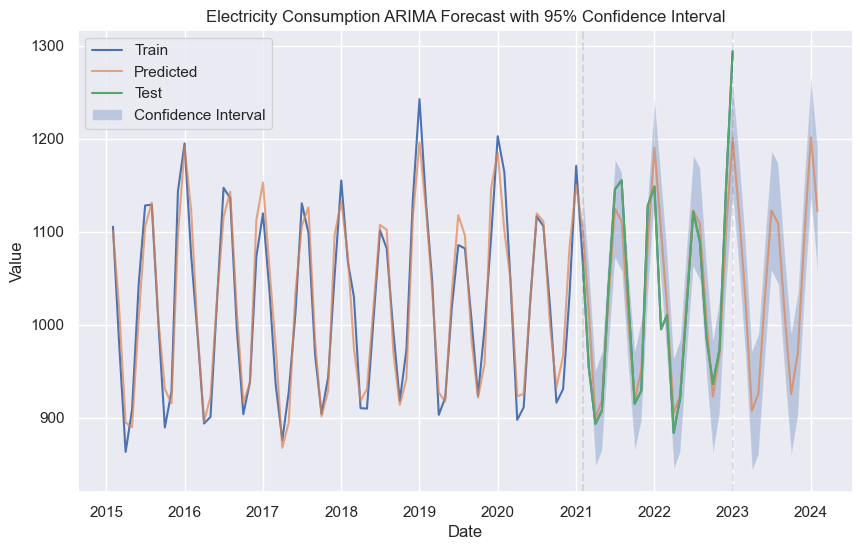

MAE (test): 82.82420980989968
RMSE (test): 105.59883699989969


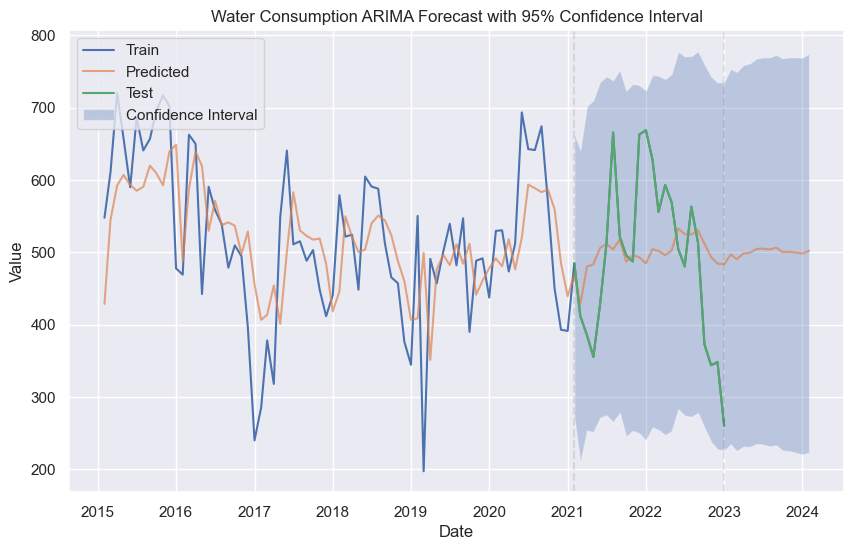

In [285]:
plot_model_params(
    gas_consumption_series, 
    arima, 
    {"order": (0, 1, 2), "seasonal_order": (1, 0, 0, 14)}, 
    gas_pt, 
    title='Gas Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=96,
    test_length=24
)

plot_model_params(
    electricity_consumption_series, 
    arima, 
    {"order": (1, 1, 1), "seasonal_order": (0, 1, 4, 12)}, 
    electricity_pt, 
    title='Electricity Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=96,
    test_length=24
)

plot_model_params(
    water_consumption_series, 
    arima, 
    {"order": (1, 1, 2), "seasonal_order": (2, 0, 0, 12)}, 
    water_pt, 
    title='Water Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=96,
    test_length=24
)

## VARMAX

Since we rejected the null hypothesis in Granger's Causality test when testing for some combination of the variables, namely, Gas Consumption causing Water Consumption and Electricity Consumption causing Gas Consumption, I will use VARMAX which is a form of multivariate time series model. It can take multiple variables as a Vector and apply many of the same Auto Regressive and Moving Average techniques to it. This could result in better out-of-sample prediction results since more data is available.

<!-- To make use of this, we can implement a $VMA$ model since both features have a $MA$ term -->

In [30]:
def varmax_rmse_wf_validation_gas(model, params, series, transformer):
    varmax_validation, varmax_prediction = walkforward_validation(varmax_, params, varmax_no_na_df, flatten=False, gap=2, step=6, verbose=False)

    for i in range(len(varmax_validation)):
        varmax_validation[i] = k_undiff(varmax_validation[i], [varmax_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]
    for i in range(len(varmax_prediction)):
        varmax_prediction[i] = k_undiff(varmax_prediction[i], [varmax_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]

        validations = varmax_validation[0]
    forecasts = varmax_prediction[0]
    for i in range(1, len(varmax_prediction)):
        validations = validations.append(varmax_validation[i])
        forecasts = forecasts.append(varmax_prediction[i])
    
    return -mean_squared_error(reverse_transform_series(validations.iloc[:, 0], transformer), reverse_transform_series(forecasts.iloc[:, 0], transformer), squared=False)

def varmax_rmse_wf_validation_water(model, params, series, transformer):
    varmax_validation, varmax_prediction = walkforward_validation(varmax_, params, varmax_no_na_df, flatten=False, gap=2, step=6, verbose=False)

    for i in range(len(varmax_validation)):
        varmax_validation[i] = k_undiff(varmax_validation[i], [varmax_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]
    for i in range(len(varmax_prediction)):
        varmax_prediction[i] = k_undiff(varmax_prediction[i], [varmax_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]

        validations = varmax_validation[0]
    forecasts = varmax_prediction[0]
    for i in range(1, len(varmax_prediction)):
        validations = validations.append(varmax_validation[i])
        forecasts = forecasts.append(varmax_prediction[i])
    
    return -mean_squared_error(reverse_transform_series(validations.iloc[:, 1], transformer), reverse_transform_series(forecasts.iloc[:, 1], transformer), squared=False)

def varmax_evaluation_descriptive(df, ori_df, model, params, idx, transformer, return_sets=False):
    varmax_validation, varmax_prediction, varmax_train, varmax_train_pred = walkforward_validation(model, params, df, flatten=False, gap=2, step=2, verbose=False, return_train=True)
    
    for i in range(len(varmax_validation)):
        varmax_validation[i] = k_undiff(varmax_validation[i], [ori_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]
    for i in range(len(varmax_prediction)):
        varmax_prediction[i] = k_undiff(varmax_prediction[i], [ori_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]
    for i in range(len(varmax_train)):
        varmax_train[i] = k_undiff(varmax_train[i], [ori_df.loc[varmax_train[i].index[0] - pd.DateOffset(months=1):varmax_train[i].index[0] - pd.DateOffset(months=1)]], None)[1:]
    for i in range(len(varmax_train_pred)):
        varmax_train_pred[i] = k_undiff(varmax_train_pred[i], [ori_df.loc[varmax_train_pred[i].index[0] - pd.DateOffset(months=1):varmax_train_pred[i].index[0] - pd.DateOffset(months=1)]], None)[1:]

    validations = varmax_validation[0]
    forecasts = varmax_prediction[0]
    trains = varmax_train[0]
    train_preds = varmax_train_pred[0]
    for i in range(1, len(varmax_prediction)):
        validations = validations.append(varmax_validation[i])
        forecasts = forecasts.append(varmax_prediction[i])
        trains = trains.append(varmax_train[i])
        train_preds = train_preds.append(varmax_train_pred[i])
        
    scores = pd.DataFrame()
    
    scores["mae_test"] = [mean_absolute_error(reverse_transform_series(validations.iloc[:, idx], transformer), reverse_transform_series(forecasts.iloc[:, idx], transformer))]
    scores["mae_train"] = [mean_absolute_error(reverse_transform_series(trains.iloc[:, idx], transformer), reverse_transform_series(train_preds.iloc[:, idx], transformer))]
    scores["rmse_test"] = [mean_squared_error(reverse_transform_series(validations.iloc[:, idx], transformer), reverse_transform_series(forecasts.iloc[:, idx], transformer), squared=False)]
    scores["rmse_train"] = [mean_squared_error(reverse_transform_series(trains.iloc[:, idx], transformer), reverse_transform_series(train_preds.iloc[:, idx], transformer), squared=False)]
    
    print("MAE (test): ", scores["mae_test"][0])
    print("MAE (train): ", scores["mae_train"][0])
    print("RMSE (test): ", scores["rmse_test"][0])
    print("RMSE (train): ", scores["rmse_train"][0])
    
    return scores

In [62]:
varmax_df = df.copy()

varmax_df["Gas Consumption (tons)"] = gas_consumption_series
varmax_df["Water Consumption (tons)"] = water_consumption_series
varmax_df["Electricity Consumption (MWh)"] = electricity_consumption_series

varmax_gas_water_df = varmax_df.drop(columns=["Electricity Consumption (MWh)"])
varmax_elec_gas_df = varmax_df.drop(columns=["Water Consumption (tons)"])

varmax_gas_water_diffed_df = varmax_gas_water_df.copy()
varmax_elec_gas_diffed_df = varmax_elec_gas_df.copy()

varmax_gas_water_diffed_df["Gas Consumption (tons)"], _, _ = k_diff(varmax_df["Gas Consumption (tons)"], 1, 0, return_discards=True)
varmax_gas_water_diffed_df["Water Consumption (tons)"], _, _ = k_diff(varmax_df["Water Consumption (tons)"], 1, 0, return_discards=True)
varmax_elec_gas_diffed_df["Gas Consumption (tons)"], _, _ = k_diff(varmax_df["Gas Consumption (tons)"], 1, 0, return_discards=True)
varmax_elec_gas_diffed_df["Electricity Consumption (MWh)"], _, _ = k_diff(varmax_df["Electricity Consumption (MWh)"], 1, 1, return_discards=True)

varmax_gas_water_diffed_df = varmax_gas_water_diffed_df.dropna()
varmax_elec_gas_diffed_df = varmax_elec_gas_diffed_df.dropna()

varmax_gas_water_diffed_df

Gas Consumption (tons)  Water Consumption (tons)
DATE                                                        
1990-02-01               -0.482310                  0.694593
1990-03-01                0.330299                 -0.978140
1990-04-01                0.345597                  0.031546
1990-05-01                0.652248                 -0.201848
1990-06-01                0.287893                  0.110997
...                            ...                       ...
2022-09-01                0.098628                 -0.375552
2022-10-01                0.794732                 -1.046254
2022-11-01               -0.153205                 -0.215973
2022-12-01                0.267551                  0.032495
2023-01-01               -0.209998                 -0.646975

[396 rows x 2 columns]

In [63]:
varmax_elec_gas_diffed_df

Gas Consumption (tons)  Electricity Consumption (MWh)
DATE                                                             
1991-02-01               -1.112116                      -0.222739
1991-03-01               -0.086600                       0.156794
1991-04-01               -0.021716                      -0.013145
1991-05-01                0.021716                       0.058557
1991-06-01                0.194272                       0.083537
...                            ...                            ...
2022-09-01                0.098628                       0.164666
2022-10-01                0.794732                       0.410814
2022-11-01               -0.153205                       0.152864
2022-12-01                0.267551                      -0.161986
2023-01-01               -0.209998                       0.841394

[384 rows x 2 columns]

In [60]:
p_range = range(0, 5)
q_range = range(0, 5)

In [101]:
# Gas cause Water

varmax_scores = []
varmax_params = []

for p in p_range:
    for q in q_range:
        if not(p == 0 and q == 0):
            print(p, q)
            varmax_params.append((p, q))
            varmax_validation, varmax_prediction = walkforward_validation(varmax, {"order": (p, q)}, varmax_gas_water_diffed_df, flatten=False, step=4)

            for i in range(len(varmax_validation)):
                varmax_validation[i] = k_undiff(varmax_validation[i], [varmax_gas_water_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]
            for i in range(len(varmax_prediction)):
                varmax_prediction[i] = k_undiff(varmax_prediction[i], [varmax_gas_water_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]

                validations = varmax_validation[0]
            forecasts = varmax_prediction[0]
            for i in range(1, len(varmax_prediction)):
                validations = validations.append(varmax_validation[i])
                forecasts = forecasts.append(varmax_prediction[i])

            varmax_score = mean_squared_error(reverse_transform_series(validations.iloc[:, 1], water_pt), reverse_transform_series(forecasts.iloc[:, 1], water_pt), squared=False)
            print("Water Consumption (VARMAX) RMSE", varmax_score)
            varmax_scores.append(varmax_score)

print("Best Score", min(varmax_scores))
print("Best parameters", varmax_params[np.argmin(varmax_scores)])

0 1


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 138.43052066224047
0 2


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 130.00456959101652
0 3


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 121.1440261251107
0 4


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 120.80213269937707
1 0


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 154.6924280134657
1 1


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 119.72439640125282
1 2


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 123.55503774834051
1 3


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 122.03704136069426
1 4


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 120.34172372783749
2 0


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 151.05024180685731
2 1


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 113.3434546992668
2 2


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 121.52509091555376
2 3


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 120.57761186131353
2 4


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 118.27485418202397
3 0


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 148.17448519075833
3 1


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 120.42028424340053
3 2


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 119.5027571935542
3 3


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 120.57162619132502
3 4


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 118.65532343899592
4 0


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 143.74232717088847
4 1


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 116.6033154346191
4 2


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 122.67214282230591
4 3


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 121.53547020523655
4 4


  0%|          | 0/7 [00:00<?, ?it/s]

Water Consumption (VARMAX) RMSE 121.92980329386958
Best Score 113.3434546992668
Best parameters (2, 1)


Optimal p, q for VARMA (Gas causing Water): 2, 1

In [64]:
# Electricity cause Gas

varmax_scores = []
varmax_params = []

for p in p_range:
    for q in q_range:
        if not(p == 0 and q == 0):
            print(p, q)
            varmax_params.append((p, q))
            varmax_validation, varmax_prediction = walkforward_validation(varmax, {"order": (p, q)}, varmax_elec_gas_diffed_df, flatten=False, step=4)

            for i in range(len(varmax_validation)):
                varmax_validation[i] = k_undiff(varmax_validation[i], [varmax_elec_gas_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]
            for i in range(len(varmax_prediction)):
                varmax_prediction[i] = k_undiff(varmax_prediction[i], [varmax_elec_gas_df.loc[varmax_validation[i].index[0] - pd.DateOffset(months=1):varmax_validation[i].index[0] - pd.DateOffset(months=1)]], None)[1:]

                validations = varmax_validation[0]
            forecasts = varmax_prediction[0]
            for i in range(1, len(varmax_prediction)):
                validations = validations.append(varmax_validation[i])
                forecasts = forecasts.append(varmax_prediction[i])

            varmax_score = mean_squared_error(reverse_transform_series(validations.iloc[:, 0], gas_pt), reverse_transform_series(forecasts.iloc[:, 1], gas_pt), squared=False)
            print("Gas Consumption (VARMAX) RMSE", varmax_score)
            varmax_scores.append(varmax_score)

print("Best Score", min(varmax_scores))
print("Best parameters", varmax_params[np.argmin(varmax_scores)])

0 1


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.6516909933974175
0 2


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.201843951061939
0 3


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.142292319526405
0 4


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.2107371363773782
1 0


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.9289804127635772
1 1


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.3371987081926364
1 2


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.1170247086827727
1 3


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.141188135667428
1 4


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.1919711511142617
2 0


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.6655398558621313
2 1


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.4382964541149184
2 2


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.205094822960973
2 3


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.180604517236145
2 4


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.1616400701488288
3 0


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.6377081202190724
3 1


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.427762820462859
3 2


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.2222999165349013
3 3


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.198184407668339
3 4


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.181953167238836
4 0


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.5147468591417312
4 1


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.3156200723616327
4 2


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.1774290976445942
4 3


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.1890316967014263
4 4


  0%|          | 0/7 [00:00<?, ?it/s]

Gas Consumption (VARMAX) RMSE 3.1799769472442208
Best Score 3.1170247086827727
Best parameters (1, 2)


Optimal p, q for VARMA (Electricity cause Gas): 1, 2

In [74]:
tsa_scores["water"] = tsa_scores["water"].append(varmax_evaluation_descriptive(varmax_gas_water_diffed_df, varmax_gas_water_df, varmax, {"order": (2, 1)}, 0, water_pt))
tsa_scores["gas"] = tsa_scores["gas"].append(varmax_evaluation_descriptive(varmax_elec_gas_diffed_df, varmax_elec_gas_df, varmax, {"order": (1, 2)}, 0, gas_pt))

MAE (test):  60.9644393164263
MAE (train):  782.5407044448101
RMSE (test):  76.32959123852366
RMSE (train):  1006.8682814470981
MAE (test):  2.649907593782821
MAE (train):  14.978199307181153
RMSE (test):  3.2873323741756915
RMSE (train):  18.214567647123523


RMSE: 473.71394805294153


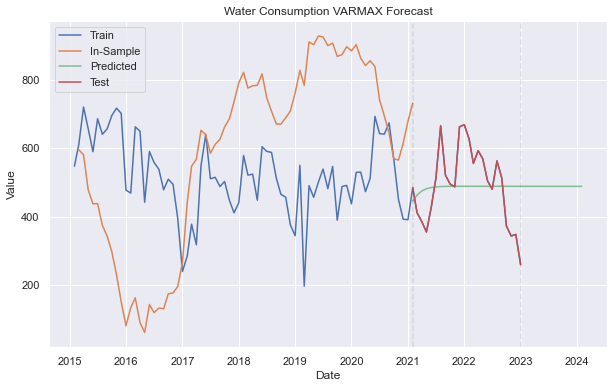

In [77]:
past_length = 96
forecast_length = 12
test_length = 24
params = {"order": (2, 1)}

varmax_fit = varmax(varmax_gas_water_diffed_df[:-test_length], params).fit()
in_sample_wrapper = varmax_fit.get_prediction(start=0, end=len(varmax_gas_water_diffed_df)-test_length)
forecast_wrapper = varmax_fit.get_prediction(start=len(varmax_gas_water_diffed_df)-test_length, end=len(varmax_gas_water_diffed_df)+forecast_length)

in_sample_series = k_undiff(
    in_sample_wrapper.predicted_mean, 
    [varmax_gas_water_df.loc[in_sample_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1):in_sample_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1)]], 
    None)[1:]
forecasted_series = k_undiff(
    forecast_wrapper.predicted_mean, 
    [varmax_gas_water_df.loc[forecast_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1):forecast_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1)]], 
    None)[1:]

water_in_sample_series = reverse_transform_series(in_sample_series.iloc[:, 1], water_pt)
water_forecasted_series = reverse_transform_series(forecasted_series.iloc[:, 1], water_pt)

series = gas_consumption_series

# Gas
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=reverse_transform_series(water_consumption_series, water_pt)[-past_length:], linestyle='solid', label="Train")
sns.lineplot(data=water_in_sample_series[-past_length+test_length:], linestyle='solid', label="In-Sample")
sns.lineplot(data=water_forecasted_series, linestyle='solid', alpha=0.7, label="Predicted")

test = reverse_transform_series(water_consumption_series, water_pt)[-test_length: ]

predict = gas_forecasted_series.loc[test.index[0]: test.index[-1]]

print(f"RMSE: {mean_squared_error(test, predict, squared=False)}")

sns.lineplot(data=test, linestyle='solid', label="Test")
plt.title("Water Consumption VARMAX Forecast")
plt.xlabel('Date')
plt.ylabel('Value')

plt.axvline(x=series.index[-test_length], color='k', linestyle='--', alpha=0.1)
plt.axvline(x=series.index[-1], color='k', linestyle='--', alpha=0.1)
plt.legend(loc="upper left")
plt.title
plt.show()

RMSE: 3.7108300977177993


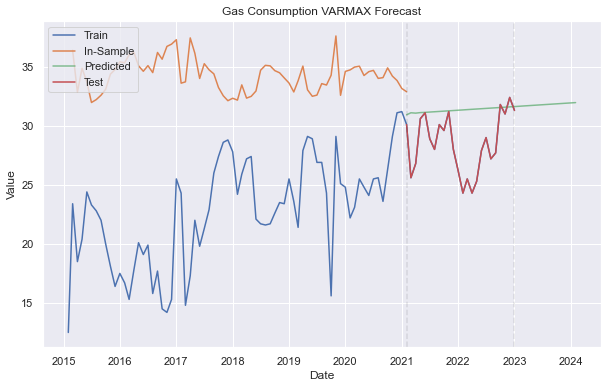

In [76]:
past_length = 96
forecast_length = 12
test_length = 24
params = {"order": (1, 2)}

varmax_fit = varmax(varmax_elec_gas_diffed_df[:-test_length], params).fit()
in_sample_wrapper = varmax_fit.get_prediction(start=0, end=len(varmax_elec_gas_diffed_df)-test_length)
forecast_wrapper = varmax_fit.get_prediction(start=len(varmax_elec_gas_diffed_df)-test_length, end=len(varmax_elec_gas_diffed_df)+forecast_length)

in_sample_series = k_undiff(
    in_sample_wrapper.predicted_mean, 
    [varmax_elec_gas_df.loc[in_sample_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1):in_sample_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1)]], 
    None)[1:]
forecasted_series = k_undiff(
    forecast_wrapper.predicted_mean, 
    [varmax_elec_gas_df.loc[forecast_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1):forecast_wrapper.predicted_mean.iloc[:, 0].index[0] - pd.DateOffset(months=1)]], 
    None)[1:]

gas_in_sample_series = reverse_transform_series(in_sample_series.iloc[:, 0], gas_pt)
gas_forecasted_series = reverse_transform_series(forecasted_series.iloc[:, 0], gas_pt)

series = gas_consumption_series

# Gas
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=reverse_transform_series(gas_consumption_series, gas_pt)[-past_length:], linestyle='solid', label="Train")
sns.lineplot(data=gas_in_sample_series[-past_length+test_length:], linestyle='solid', label="In-Sample")
sns.lineplot(data=gas_forecasted_series, linestyle='solid', alpha=0.7, label="Predicted")

test = reverse_transform_series(gas_consumption_series, gas_pt)[-test_length: ]

predict = gas_forecasted_series.loc[test.index[0]: test.index[-1]]

print(f"RMSE: {mean_squared_error(test, predict, squared=False)}")

sns.lineplot(data=test, linestyle='solid', label="Test")
plt.title("Gas Consumption VARMAX Forecast")
plt.xlabel('Date')
plt.ylabel('Value')

plt.axvline(x=series.index[-test_length], color='k', linestyle='--', alpha=0.1)
plt.axvline(x=series.index[-1], color='k', linestyle='--', alpha=0.1)
plt.legend(loc="upper left")
plt.title
plt.show()

**Observations**
* Even though the test RMSE tells me that VARMAX performs well, the plots look extremely irregular indicating something is off with the predictions.

### Hyperparameter Tuning: Artificial Bee Colony
Since there is a large number of parameters to tune for some of the models, I opt to use the ABC tuning algorithm instead of a more exhaustive method like GridSearch to reduce tuning time.

In [226]:
bool_option = ([True, False], "str")

all_model_settings = [
    {
        "tsa_model": hwes,
        "tunable_space": {
            "trend": (["add"], "str"),
#             "trend": (["add", "mul", None], "str"),
            "damped_trend": bool_option,
            "seasonal": (["add", None], "str"),
#             "seasonal": (["add", "mul", None], "str"),
            "seasonal_periods": (2, 48, "int"),
            "initialization_method": (["estimated", "heuristic"], "str"),
#             "use_boxcox": bool_option
        },
        "default_hyperparameters": {
            "trend": "add",
            "damped_trend": False,
            "seasonal": None,
            "seasonal_periods": None,
            "initialization_method": "estimated",
#             "use_boxcox": False
        },
        "common_parameters": {
            "use_boxcox": False
        }
    },
    {
        "tsa_model": arima_,
        "tunable_space": {
            "p": (0, 3, "int"),
#             "d": (0, 3, "int"),
            "q": (0, 3, "int"),
            "P": (0, 3, "int"),
#             "D": (0, 3, "int"),
            "Q": (0, 3, "int"),
#             "M": (12, 36, "int"),
#             "trend": (["n", "t"], "str"),
#             "trend": (["c"], "str"),
#             "trend": (["n", "c", "t", "ct"], "str"),
            "enforce_stationarity": bool_option,
            "enforce_invertibility": bool_option,
#             "concentrate_scale": bool_option,
            "trend_offset": (0, 5, "int")
        },
        "default_hyperparameters": {
            "p": 0,
#             "d": 0,
            "q": 0,
            "P": 0,
#             "D": 0,
            "Q": 0,
#             "M": 12,
#             "trend": "c",
            
            "enforce_stationarity": True,
            "enforce_invertibility": True,
#             "concentrate_scale": bool_option,
            "trend_offset": 1
        },
        "common_parameters": {
#             "n_jobs": -1,
#             "random_state": 23
        }
#         "scorer": opt_pb_f1_scorer
    },
    {
        "tsa_model": sarimax,
        "tunable_space": {
#             "p": (0, 5, "int"),
# #             "d": (0, 5, "int"),
#             "q": (0, 5, "int"),
#             "P": (0, 5, "int"),
# #             "D": (0, 5, "int"),
#             "Q": (0, 5, "int"),
#             "M": (6, 24, "int"),
#             "trend": (["n", "t"], "str"),
            "trend": (["n", "c", "t", "ct"], "str"),
            "measurement_error": bool_option,
            "simple_differencing": bool_option,
#             "hamilton_representation": bool_option,
            "enforce_stationarity": bool_option,
            "enforce_invertibility": bool_option,
#             "concentrate_scale": bool_option,
            "trend_offset": (0, 5, "int")
        },
        "default_hyperparameters": {
#             "p": 1,
# #             "d": 0,
#             "q": 0,
#             "P": 0,
# #             "D": 0,
#             "Q": 0,
#             "M": 12,
            "trend": "n",
            "measurement_error": False,
            "simple_differencing": False,
#             "hamilton_representation": False,
            "enforce_stationarity": True,
            "enforce_invertibility": True,
#             "concentrate_scale": bool_option,
            "trend_offset": 1
        },
        "common_parameters": {
#             "n_jobs": -1,
#             "random_state": 23
        }
#         "scorer": opt_pb_f1_scorer
    },
    {
        "tsa_model": varmax_,
        "tunable_space": {
            "p": (0, 4, "int"),
#             "d": (0, 5, "int"),
            "q": (0, 4, "int"),
            "error_cov_type": (['diagonal', 'unstructured'], 'str'),
            "trend": (["n", "c", "t", "ct"], "str"),
            "measurement_error": bool_option,
            "simple_differencing": bool_option,
#             "hamilton_representation": bool_option,
            "enforce_stationarity": bool_option,
            "enforce_invertibility": bool_option,
#             "concentrate_scale": bool_option,
            "trend_offset": (0, 5, "int")
        },
        "default_hyperparameters": {
            "p": 1,
# #             "d": 0,
            "q": 0,
#             "P": 0,
# #             "D": 0,
#             "Q": 0,
#             "M": 12,
            "trend": "n",
            "error_cov_type": "unstructured",
            "measurement_error": False,
            "simple_differencing": False,
#             "hamilton_representation": False,
            "enforce_stationarity": True,
            "enforce_invertibility": True,
#             "concentrate_scale": bool_option,
            "trend_offset": 1
        },
        "common_parameters": {
#             "n_jobs": -1,
#             "random_state": 23
        }
#         "scorer": opt_pb_f1_scorer
    },
]

In [42]:
import random
import copy
import math

class Bee:
    def __init__(self, params, score, stay_limit, employed):
        self._params = params
        self._score = score
        self._is_employed = employed
        self._stay_limit = stay_limit
        self._abandon_count = 0
        # print(f'stay limit: {self._stay_limit}')
        
    def abandon(self):
        self._abandon_count += 1
        if self._abandon_count >= self._stay_limit:
            return True
        else:
            return False
        
    def is_better_food(self, new_score):
        if new_score > self._score:
            return True
        else:
            return False

from multiprocess import Pool
from bisect import bisect

class ArtificalBeeColony:
    def __init__(self,
                 tsa_model,
                 series,
                 search_space,
                 common_params, 
                 default_params, 
                 fitness_fn, 
                 fitness_fn_params, 
                 transformer,
                 n_employed_bees, 
                 n_processes, 
                 stay_limit=5, 
                 baseline_score=0, 
                 mutation_chance=0.5, 
                 mutation_std=0.1, 
                 ignore_warnings=True
                ):
        self._tsa_model = tsa_model
        self._series = series
        self._search_space = search_space
        self._common_params = common_params
        self._default_params = default_params
        self._fitness_fn = fitness_fn
        self._fitness_fn_params = fitness_fn_params
        self._transformer = transformer
#         self._scoring_metric = scoring_metric
        self._n_employed_bees = n_employed_bees
        self._best_score = 0
        self._best_params = None
        self._n_processes = n_processes
        self._mutation_chance = mutation_chance
        self._mutation_std = mutation_std
        self._stay_limit = stay_limit
        self._baseline_score = baseline_score
        self._ignore_warnings = ignore_warnings
        self._bees = []
    
    def score(self, params):
        print(params)
        params = copy.deepcopy(params)
        params.update(self._common_params)
        if self._ignore_warnings:
            score = None
            try: 
                score = self._fitness_fn(self._tsa_model, params, self._series, self._transformer)
                return (params, score)
            except KeyboardInterrupt as err:
                raise KeyboardInterrupt(err)
            except:
                return (params, self._baseline_score)
        else:
            score = self._fitness_fn(self._tsa_model, params, self._series, self._transformer)
            print(score)
            return (params, score)
        
    
    def clamp(self, value, c_range):
        if value > c_range[1]:
            value = c_range[1]
        if value < c_range[0]:
            value = c_range[0]
        return value

    def random_food(self):
        food = {}
        for key, value in self._search_space.items():
            if value[-1] == "int":
                food[key] = np.random.randint(value[0], value[1])
            elif value[-1] == "float":
                food[key] = np.random.uniform(value[0], value[1])
            elif value[-1] == "str":
                food[key] = np.random.choice(value[0])
            elif value[-1] == "arr":
                food[key] = np.random.randint(value[0], value[1], size=np.random.randint(1, value[2]))

            if value[-1] == "int" or value[-1] == "float":
                food[key] = self.clamp(food[key], value)
            if value[-1] == "arr":
                food[key] = [self.clamp(x, value) for x in food[key]]
        return food
    
    def mutate_food(self, params):
        food = {}
        for key, value in self._search_space.items():
            if random.random() < self._mutation_chance:
                if params[key] == 0:
                    mute_param = 1
                else:
                    mute_param = params[key]
                if value[-1] == "int":
                    if params[key] is None:
                        params[key] = 0
                        mute_param = 1
                    food[key] = int(params[key] + mute_param * np.random.normal(loc=0, scale=self._mutation_std))
                elif value[-1] == "float":
                    if params[key] is None:
                        params[key] = 0
                        mute_param = 1
                    food[key] = params[key] + mute_param * np.random.normal(loc=0, scale=self._mutation_std)
                elif value[-1] == "str":
                    food[key] = np.random.choice(value[0])
                elif value[-1] == "arr":
                    food[key] = [int(x + x * np.random.normal(loc=0, scale=self._mutation_std)) for x in params[key]]

                if value[-1] == "int" or value[-1] == "float":
                    food[key] = self.clamp(food[key], value)
                if value[-1] == "arr":
                    food[key] = [self.clamp(x, value) for x in food[key]]
            else:
                food[key] = params[key]
        return food

    def choose_bee(self):
        for b in self._bees:
            if math.isnan(b._score):
                b._score = self._baseline_score
        lowest_score = np.min([b._score for b in self._bees])
        fitness_sum = sum((b._score - lowest_score) for b in self._bees)
        if fitness_sum == 0:
            idx = np.random.randint(len(self._bees))
        else:
            probabilities = [(b._score - self._baseline_score) / fitness_sum for b in self._bees]
            cdf_vals = []
            cumsum = 0
            for p in probabilities:
                cumsum += p
                cdf_vals.append(cumsum)
            idx = bisect(cdf_vals, random.random())
        while idx >= len(self._bees):
            idx = np.random.randint(len(self._bees))
        return self._bees[idx]

    def best(self):
        idx = np.argmax([b._score for b in self._bees])
        return self._bees[idx]
    
    def init_colony(self):
        self._bees = []

        if self._n_processes > 1:
            bee_pool = Pool(processes=self._n_processes)
        employed_results = []
            
        for _ in range(self._n_employed_bees-1):
            params = self.random_food()
            if self._n_processes > 1:
                employed_results.append(bee_pool.apply_async(
                    self.score, [params]
                ))
            else:
                employed_results.append(self.score(
                    params
                ))
                
        if self._n_processes > 1:
            bee_pool.close()
            bee_pool.join()
            employed_results = [r.get() for r in employed_results]
            
        for result in employed_results:

            self._bees.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                True
            ))
        
        
        self._bees.append(Bee(
            self._default_params,
            self.score(self._default_params)[1],
            True,
            self._stay_limit)
        )

          
        if self._n_processes > 1:
            bee_pool = Pool(processes=self._n_processes)
        onlooker_results = []

        for _ in range(self._n_employed_bees):

            chosen_employed = self.choose_bee()
            neighbor_food = self.mutate_food(
                chosen_employed._params
            )

            if self._n_processes > 1:
                onlooker_results.append(bee_pool.apply_async(
                    self.score, [params]
                ))
            else:
                onlooker_results.append(self.score(
                    params
                ))

        if self._n_processes > 1:

            bee_pool.close()
            bee_pool.join()
            onlooker_results = [r.get() for r in onlooker_results]

        for result in onlooker_results:

            self._bees.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                False
            ))
  
    def next_generation(self):
        if self._n_processes > 1:
            bee_pool = Pool(processes=self._n_processes)
        new_employed_results = []
        new_onlooker_results = []
        new_position_results = []
        current_positions = []
        best_bee = self.best()

        next_bee_generation = []

        for bee in self._bees:

            if bee == best_bee:

                next_bee_generation.append(bee)

            else:
                if bee.abandon():

                    if bee._is_employed:

                        new_params = self.random_food()
                        if self._n_processes > 1:
                            new_employed_results.append(bee_pool.apply_async(
                                self.score,
                                [new_params,]
                            ))
                        else:
                            new_employed_results.append(self.score(
                                new_params
                            ))

                    else:

                        chosen_bee = self.choose_bee()
                        neighbor_food = self.mutate_food(
                            chosen_bee._params
                        )
                        if self._n_processes > 1:
                            new_onlooker_results.append(bee_pool.apply_async(
                                self.score,
                                [neighbor_food]
                            ))
                        else:
                            new_onlooker_results.append(self.score(
                                neighbor_food
                            ))

                else:

                    current_positions.append(bee)

                    if bee._is_employed:
                        neighbor_food = self.mutate_food(bee._params)
                    else: 
                        chosen_bee = self.choose_bee()
                        neighbor_food = self.mutate_food(
                            chosen_bee._params
                        )
                    if self._n_processes > 1:
                        new_position_results.append(bee_pool.apply_async(
                            self.score,
                            [neighbor_food]
                        ))
                    else:
                        new_position_results.append(self.score(
                            neighbor_food
                        ))


        if self._n_processes > 1:

            bee_pool.close()
            bee_pool.join()
            new_employed_results = [r.get() for r in new_employed_results]
            new_onlooker_results = [r.get() for r in new_onlooker_results]
            new_position_results = [r.get() for r in new_position_results]

        for result in new_employed_results:

            next_bee_generation.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                True
            ))

        for result in new_onlooker_results:

            next_bee_generation.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                False
            ))

        for idx, result in enumerate(new_position_results):

            bee_to_compare = current_positions[idx]
            if bee_to_compare.is_better_food(result[1]):
                if bee._is_employed:
                    next_bee_generation.append(Bee(
                        result[0],
                        result[1],
                        self._stay_limit,
                        True
                    ))
                else:
                    next_bee_generation.append(Bee(
                        result[0],
                        result[1],
                        self._stay_limit,
                        False
                    ))
            else:
                next_bee_generation.append(bee_to_compare)

        self._bees = next_bee_generation
            
    def fit(self, n_iter, threshold, verbose=True):
        print("Initializing Bee Colony...")
        self.init_colony()
        from tqdm.notebook import tqdm
        print("Optimizing...")
        for i in tqdm(range(n_iter)):
            best_bee = self.best()
            if i % 2 == 0 and verbose:
                print(f'Best Score: {best_bee._score}')
                print(f'Best Params: {best_bee._params}')
            if best_bee._score > threshold:
                break
            self.next_generation()
        print(f'Best Score: {best_bee._score}')
        print(f'Best Params: {best_bee._params}')

    # def 

In [ ]:
def rmse_wf_validation(model, params, series, transformer):
    wf_valid, wf_pred = walkforward_validation(model, params, series, gap=2, step=4, verbose=False)
    return -mean_squared_error(reverse_transform_series(wf_valid, transformer), reverse_transform_series(wf_pred, transformer), squared=False)

In [235]:
# We can save the trained model clf using pickle
import pickle

tuned_ABCs = []
for i, model_setting in enumerate(all_model_settings[0:1]):
    tuned_ABCs.append(ArtificalBeeColony(
        model_setting["tsa_model"],
        electricity_consumption_series,
        model_setting["tunable_space"],
        model_setting["common_parameters"],
        model_setting["default_hyperparameters"],
        rmse_wf_validation,
        {},
        electricity_pt,
        10,
        1,
        stay_limit=1,
        mutation_chance=0.6,
        mutation_std=0.4,
        baseline_score=-1000,
        ignore_warnings=False
        ))
    tuned_ABCs[i].fit(100, 1000)
    pickle.dump(tuned_ABCs[i].best(), open(f'pickled/ABC/Gas Consumption/{model_setting["tsa_model"](gas_consumption_series, {}).__class__.__name__}.pkl', 'wb'))

Initializing Bee Colony...
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 45, 'initialization_method': 'estimated'}
-158.91590139482443
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 11, 'initialization_method': 'heuristic'}
-113.51658753536212
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 4, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 46, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 24, 'initialization_method': 'estimated'}
-148.5680959328079
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 19, 'initialization_method': 'estimated'}
-150.03233056986903
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 13, 'initialization_method': 'heuristic'}
-148.56809593280

  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: -113.51658753536212
Best Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 11, 'initialization_method': 'heuristic', 'use_boxcox': False}
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 26, 'initialization_method': 'heuristic'}
-153.96410601775906
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 35, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 13, 'initialization_method': 'heuristic'}
-148.5680959328079
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 6, 'initialization_method': 'estimated'}
-47.69325240072313
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 36, 'initialization_method': 'estimated'}
-50.38136469558918
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 42, 'initialization_method': 'estimated

-42.56571522808076
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 4, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 13, 'initialization_method': 'estimated'}
-143.65264109388195
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'estimated'}
-150.10265372219234
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 31, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 26, 'initialization_method': 'estimated'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 23, 'initialization_method': 'estimated'}
-151.7080483247815
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 21, 'initialization_method': 'heuristic'}
-149.24674036314093
{'t

-160.13967890272886
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 23, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 19, 'initialization_method': 'estimated'}
-149.24404357875906
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 22, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 21, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 32, 'initialization_method': 'estimated'}
-160.26832736853328
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 22, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 15, 'initialization_method': 'estimated'}
-148.5680959328079
{

-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 29, 'initialization_method': 'heuristic'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 4, 'initialization_method': 'estimated'}
-148.80266939468228
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 47, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 42, 'initialization_method': 'heuristic'}
-64.26466300599563
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 44, 'initialization_method': 'estimated'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 9, 'initialization_method': 'heuristic'}
-147.95640635242648
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 17, 'initialization_method': 'heuristic'}
-154.0311939068065
{'trend'

-148.80266939468228
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 31, 'initialization_method': 'estimated'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 4, 'initialization_method': 'heuristic'}
-148.80266939468228
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 36, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 11, 'initialization_method': 'estimated'}
-113.51658753536212
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 16, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 27, 'initialization_method': 'estimated'}
-155.23027240287004
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 19, 'initialization_method': 'estimated'}
-149.24404357875906
{'

-104.61049629534872
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 21, 'initialization_method': 'estimated'}
-149.24674036314093
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 34, 'initialization_method': 'heuristic'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 35, 'initialization_method': 'heuristic'}
-170.04909121560405
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 23, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 24, 'initialization_method': 'heuristic'}
-41.592876695913674
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 24, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 22, 'initialization_method': 'estimated'}
-149.21253320008157


-149.24404357875906
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 23, 'initialization_method': 'estimated'}
-151.7080483247815
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 47, 'initialization_method': 'heuristic'}
-148.5680959328079
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 11, 'initialization_method': 'estimated'}
-130.2042276987179
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 45, 'initialization_method': 'estimated'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 24, 'initialization_method': 'estimated'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 24, 'initialization_method': 'estimated'}
-40.731873326949376
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 24, 'initialization_method': 'estimated'}
-40.731873326949376
{'trend

-156.84909053419952
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 2, 'initialization_method': 'estimated'}
-148.0786351728811
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 12, 'initialization_method': 'estimated'}
-41.90794225620957
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 6, 'initialization_method': 'heuristic'}
-46.670623189128115
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 24, 'initialization_method': 'heuristic'}
-148.5680959328079
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 24, 'initialization_method': 'heuristic'}
-40.731873326949376
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 24, 'initialization_method': 'heuristic'}
-40.731873326949376
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 29, 'initialization_method': 'estimated'}
-157.10340129014205
{'tre

-147.13517349487515
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 33, 'initialization_method': 'heuristic'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 44, 'initialization_method': 'estimated'}
-158.1150359021839
{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 2, 'initialization_method': 'heuristic'}
-148.5680959328079
{'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 28, 'initialization_method': 'heuristic'}
-148.04152863153863
{'trend': 'add', 'damped_trend': False, 'seasonal': None, 'seasonal_periods': 26, 'initialization_method': 'estimated'}
-149.91607453825222
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 24, 'initialization_method': 'heuristic'}
-40.731873326949376
{'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 21, 'initialization_method': 'heuristic'}
-148.35780762233975
{'t

KeyboardInterrupt: 

### Hyperparameter Tuning Results: SARIMA

In [55]:
print("Gas Consumption Parameters: \n", pickle.load(open(f'pickled/ABC/Gas Consumption/SARIMAX.pkl', 'rb'))._params)

print("\nElectricity Consumption Parameters: \n", pickle.load(open(f'pickled/ABC/Electricity Consumption/SARIMAX.pkl', 'rb'))._params)

print("\nWater Consumption Parameters: \n", pickle.load(open(f'pickled/ABC/Water Consumption/SARIMAX.pkl', 'rb'))._params)

Gas Consumption Parameters: 
 {'trend': 'c', 'measurement_error': True, 'simple_differencing': False, 'enforce_stationarity': False, 'enforce_invertibility': True, 'trend_offset': 4, 'order': (0, 1, 2), 'seasonal_order': (0, 0, 1, 14)}

Electricity Consumption Parameters: 
 {'trend': 'c', 'measurement_error': True, 'simple_differencing': False, 'enforce_stationarity': False, 'enforce_invertibility': False, 'trend_offset': 2, 'order': (1, 1, 1), 'seasonal_order': (0, 1, 4, 12)}

Water Consumption Parameters: 
 {'trend': 'n', 'measurement_error': True, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'trend_offset': 4, 'order': (1, 1, 2), 'seasonal_order': (2, 0, 0, 12)}


In [88]:
tsa_scores["gas"] = tsa_scores["gas"].append(evaluation_descriptive(gas_consumption_series, sarimax, pickle.load(open(f'pickled/ABC/Gas Consumption/SARIMAX.pkl', 'rb'))._params, gas_pt, return_scores=True))
tsa_scores["electricity"] = tsa_scores["electricity"].append(evaluation_descriptive(electricity_consumption_series, sarimax, pickle.load(open(f'pickled/ABC/Electricity Consumption/SARIMAX.pkl', 'rb'))._params, electricity_pt, return_scores=True))
tsa_scores["water"] = tsa_scores["water"].append(evaluation_descriptive(water_consumption_series, sarimax, pickle.load(open(f'pickled/ABC/Water Consumption/SARIMAX.pkl', 'rb'))._params, water_pt, return_scores=True))

MAE (test): 2.003144560332195
RMSE (test): 2.359555900434219


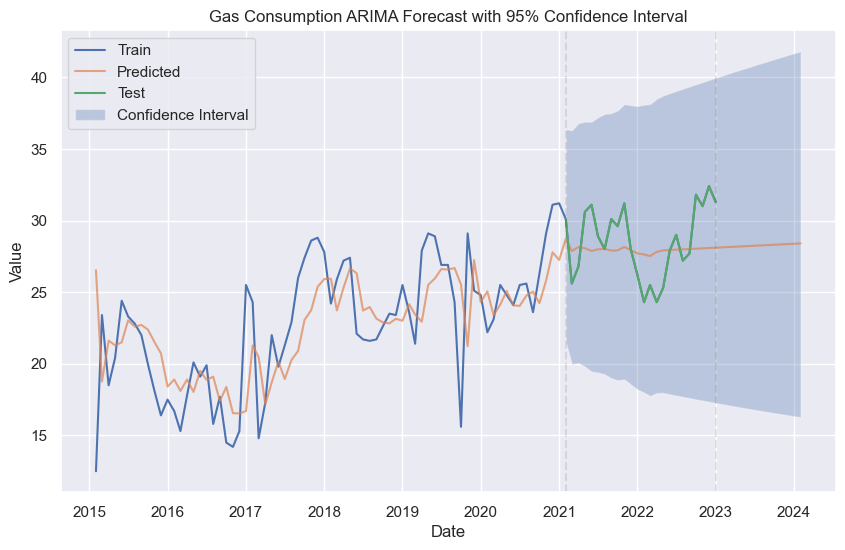

MAE (test): 28.617484520697413
RMSE (test): 40.56621676179449


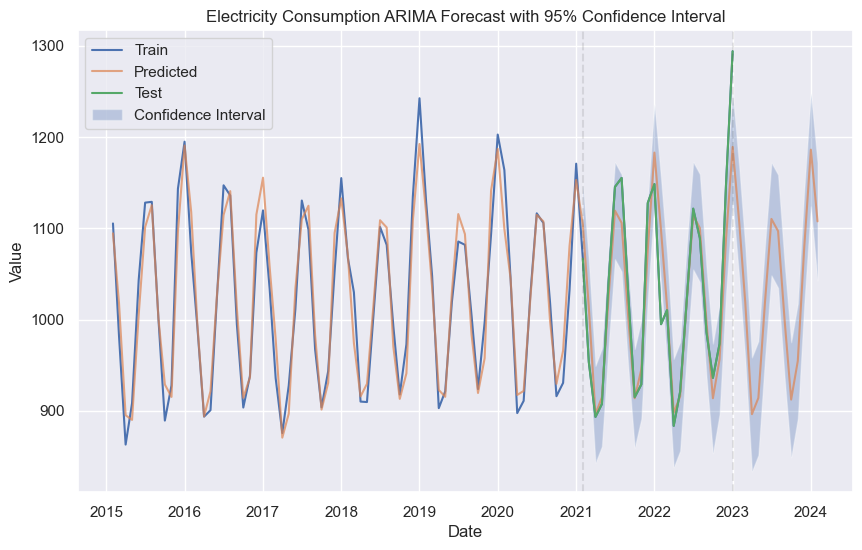

MAE (test): 85.82681093800795
RMSE (test): 106.59544264041853


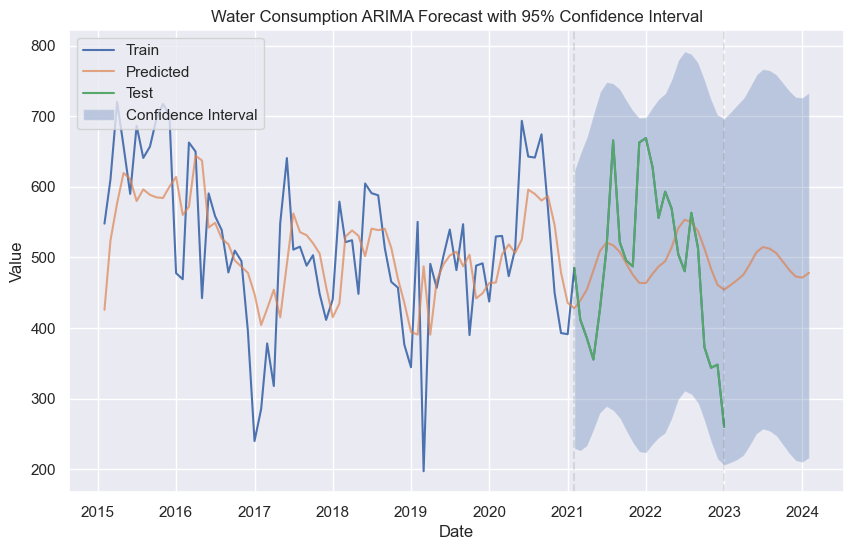

In [287]:
plot_model_params(
    gas_consumption_series, 
    sarimax, 
    pickle.load(open(f'pickled/ABC/Gas Consumption/SARIMAX.pkl', 'rb'))._params, 
    gas_pt, 
    title='Gas Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=96,
    test_length=24
)

plot_model_params(
    electricity_consumption_series, 
    sarimax, 
    pickle.load(open(f'pickled/ABC/Electricity Consumption/SARIMAX.pkl', 'rb'))._params, 
    electricity_pt, 
    title='Electricity Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=96,
    test_length=24
)

plot_model_params(
    water_consumption_series, 
    sarimax, 
    pickle.load(open(f'pickled/ABC/Water Consumption/SARIMAX.pkl', 'rb'))._params, 
    water_pt, 
    title='Water Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=96,
    test_length=24
)

### Hyperparameter Tuning Results: Holt-Winter's Exponential Smoothing

In [69]:
print("Gas Consumption Parameters: \n", pickle.load(open(f'pickled/ABC/Gas Consumption/HWES.pkl', 'rb'))._params)

print("\nElectricity Consumption Parameters: \n", pickle.load(open(f'pickled/ABC/Electricity Consumption/HWES.pkl', 'rb'))._params)

print("\nWater Consumption Parameters: \n", pickle.load(open(f'pickled/ABC/Water Consumption/HWES.pkl', 'rb'))._params)

Gas Consumption Parameters: 
 {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 36, 'initialization_method': 'estimated', 'use_boxcox': False}

Electricity Consumption Parameters: 
 {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 24, 'initialization_method': 'estimated', 'use_boxcox': False}

Water Consumption Parameters: 
 {'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 44, 'initialization_method': 'estimated', 'use_boxcox': False}


In [57]:
tsa_scores["gas"] = tsa_scores["gas"].append(evaluation_descriptive(gas_consumption_series, hwes, {}, gas_pt, return_scores=True, plot_arima=False, return_coefficients=False, is_hwes=True))
tsa_scores["electricity"] = tsa_scores["electricity"].append(evaluation_descriptive(electricity_consumption_series, hwes, {}, electricity_pt, return_scores=True, plot_arima=False, return_coefficients=False, is_hwes=True))
tsa_scores["water"] = tsa_scores["water"].append(evaluation_descriptive(water_consumption_series, hwes, {}, water_pt, return_scores=True, plot_arima=False, return_coefficients=False, is_hwes=True))

AIC:  -239.64375381156736


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  2.4080061700599367
MAE (train):  0
RMSE (test):  3.1185787723068548
RMSE (train):  0
AIC:  -535.3806058283955


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  116.17916650440775
MAE (train):  0
RMSE (test):  138.68556400848195
RMSE (train):  0
AIC:  -193.58420943996398


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  106.4568994846988
MAE (train):  0
RMSE (test):  130.2133239901612
RMSE (train):  0


In [72]:
print("MAE (test):  2.4080061700599367\nRMSE (test):  3.1185787723068548")

print("MAE (test):  116.17916650440775\nRMSE (test):  138.68556400848195")

print("MAE (test):  106.4568994846988\nRMSE (test):  130.2133239901612")

MAE (test):  2.4080061700599367
RMSE (test):  3.1185787723068548
MAE (test):  116.17916650440775
RMSE (test):  138.68556400848195
MAE (test):  106.4568994846988
RMSE (test):  130.2133239901612


MAE (test): 2.283070889330169
RMSE (test): 2.799318605517012


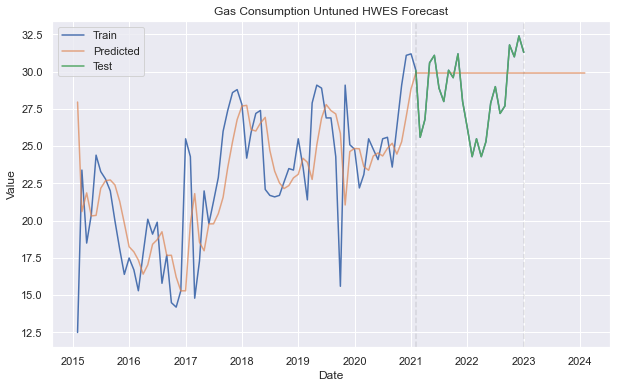

MAE (test): 152.38749810969824
RMSE (test): 176.3203566348815


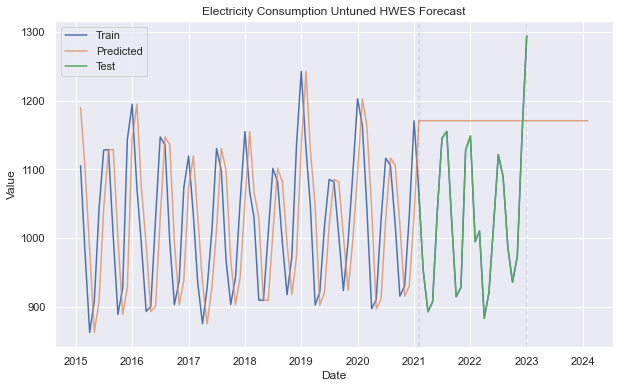

MAE (test): 59.05157788424297
RMSE (test): 72.7657631048426


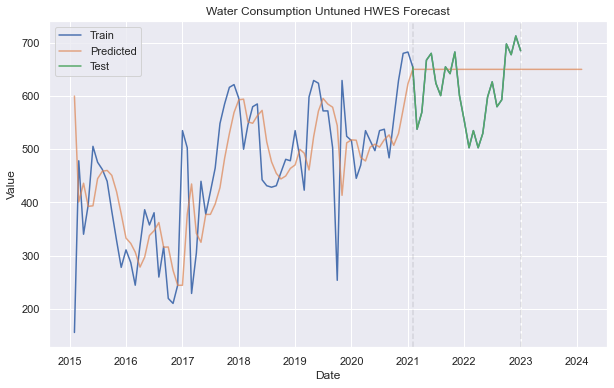

In [62]:
plot_model_params(
    gas_consumption_series, 
    hwes, 
    {}, 
    gas_pt, 
    title='Gas Consumption Untuned HWES Forecast',
    past_length=96,
    test_length=24,
    is_hwes=True,
    plot_conf_int=False
)

plot_model_params(
    electricity_consumption_series, 
    hwes, 
    {},
    electricity_pt, 
    title='Electricity Consumption Untuned HWES Forecast',
    past_length=96,
    test_length=24,
    is_hwes=True,
    plot_conf_int=False
)

plot_model_params(
    gas_consumption_series, 
    hwes, 
    {}, 
    water_pt, 
    title='Water Consumption Untuned HWES Forecast',
    past_length=96,
    test_length=24,
    is_hwes=True,
    plot_conf_int=False
)


In [46]:
tsa_scores["gas"] = tsa_scores["gas"].append(evaluation_descriptive(gas_consumption_series, hwes, pickle.load(open(f'pickled/ABC/Gas Consumption/HWES.pkl', 'rb'))._params, gas_pt, return_scores=True, plot_arima=False, return_coefficients=False, is_hwes=True))
tsa_scores["electricity"] = tsa_scores["electricity"].append(evaluation_descriptive(electricity_consumption_series, hwes, pickle.load(open(f'pickled/ABC/Electricity Consumption/HWES.pkl', 'rb'))._params, electricity_pt, return_scores=True, plot_arima=False, return_coefficients=False, is_hwes=True))
tsa_scores["water"] = tsa_scores["water"].append(evaluation_descriptive(water_consumption_series, hwes, pickle.load(open(f'pickled/ABC/Water Consumption/HWES.pkl', 'rb'))._params, water_pt, return_scores=True, plot_arima=False, return_coefficients=False, is_hwes=True))

AIC:  -193.06607679378027


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  2.061169582476098
MAE (train):  0
RMSE (test):  2.685972340559238
RMSE (train):  0
AIC:  -1316.043576320356


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  30.17105853506808
MAE (train):  0
RMSE (test):  39.66503384845227
RMSE (train):  0
AIC:  -152.8129216617915


  0%|          | 0/15 [00:00<?, ?it/s]

MAE (test):  97.27641004265811
MAE (train):  0
RMSE (test):  120.11915522640722
RMSE (train):  0


MAE (test): 2.1364532730625334
RMSE (test): 2.607434383313296


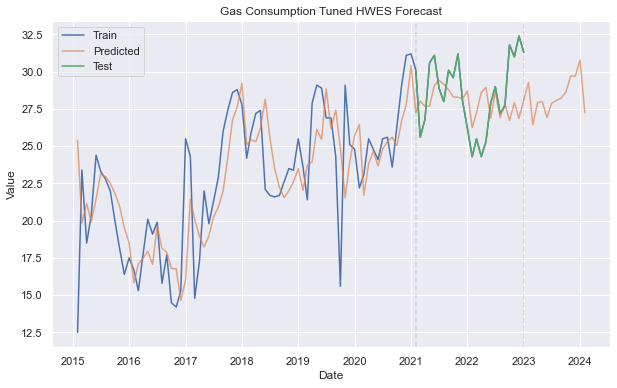

MAE (test): 33.85792224857919
RMSE (test): 46.01787454310246


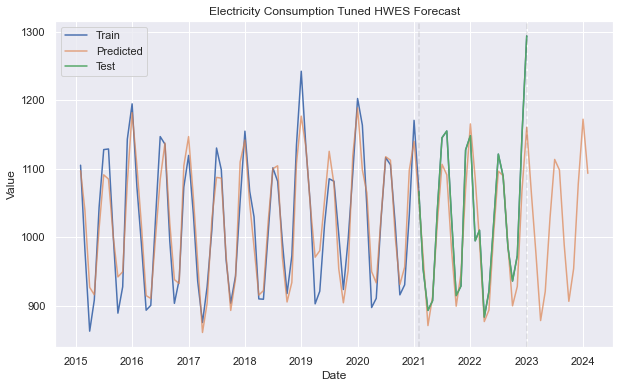

MAE (test): 65.3553433660503
RMSE (test): 78.35565997882517


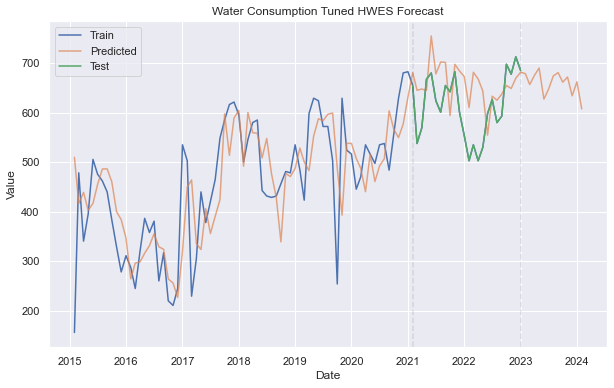

In [63]:
plot_model_params(
    gas_consumption_series, 
    hwes, 
    pickle.load(open(f'pickled/ABC/Gas Consumption/HWES.pkl', 'rb'))._params, 
    gas_pt, 
    title='Gas Consumption Tuned HWES Forecast',
    past_length=96,
    test_length=24,
    is_hwes=True,
    plot_conf_int=False
)

plot_model_params(
    electricity_consumption_series, 
    hwes, 
    pickle.load(open(f'pickled/ABC/Electricity Consumption/HWES.pkl', 'rb'))._params,
    electricity_pt, 
    title='Electricity Consumption Tuned HWES Forecast',
    past_length=96,
    test_length=24,
    is_hwes=True,
    plot_conf_int=False
)

plot_model_params(
    gas_consumption_series, 
    hwes, 
    pickle.load(open(f'pickled/ABC/Water Consumption/HWES.pkl', 'rb'))._params, 
    water_pt, 
    title='Water Consumption Tuned HWES Forecast',
    past_length=96,
    test_length=24,
    is_hwes=True,
    plot_conf_int=False
)


In [80]:
tsa_scores["gas"].index = ["base_sarima", "auto_arima", "base_varmax", "tuned_base_sarima", "tuned_hwes", "hwes"]
tsa_scores["electricity"].index = ["base", "tuned_base_sarima", "tuned_hwes", "hwes"]
tsa_scores["water"].index = ["base_sarima", "auto_arima", "base_varmax", "tuned_auto_arima", "tuned_hwes", "hwes"]

In [81]:
print("Gas Consumption:")

tsa_scores["gas"]

Gas Consumption:


mae_test  mae_train  rmse_test  rmse_train
base_sarima        2.348216   2.485460   3.027845    3.704156
auto_arima         2.371986   2.398876   3.032369    3.574951
base_varmax        2.649908  14.978199   3.287332   18.214568
tuned_base_sarima  2.357685   2.469937   2.996810    3.634326
tuned_hwes         2.061170   0.000000   2.685972    0.000000
hwes               2.408006   0.000000   3.118579    0.000000

In [82]:
print("Electricity Consumption:")

tsa_scores["electricity"]

Electricity Consumption:


mae_test  mae_train   rmse_test  rmse_train
base                27.227981  19.465739   34.916816   28.718052
tuned_base_sarima   26.118219  20.574414   34.027548   30.522336
tuned_hwes          30.171059   0.000000   39.665034    0.000000
hwes               116.179167   0.000000  138.685564    0.000000

In [83]:
print("Water Consumption:")

tsa_scores["water"]

Water Consumption:


mae_test   mae_train   rmse_test   rmse_train
base_sarima        86.987716   74.458845  107.624587   102.813271
auto_arima         82.213413   73.323133  102.176881   101.657298
base_varmax        60.964439  782.540704   76.329591  1006.868281
tuned_auto_arima   80.065222   73.617893   99.721392   101.602199
tuned_hwes         97.276410    0.000000  120.119155     0.000000
hwes              106.456899    0.000000  130.213324     0.000000

## Final Models

HWES is the best performing for Gas Consumption and SARIMA is the best performing for Electricity Consumption.

Even though VARMAX, for Water Consumption, performed better than the rest of the models in terms of the test RMSE and MAE, it fails by comparison in terms of its training score. Plotting the in-sample and out-of-sample forecasts also resulted in a very irregular plot. Thus, I choose SARIMA in place of it.

MAE (test): 0.8161350210288632
RMSE (test): 0.8161350210288632


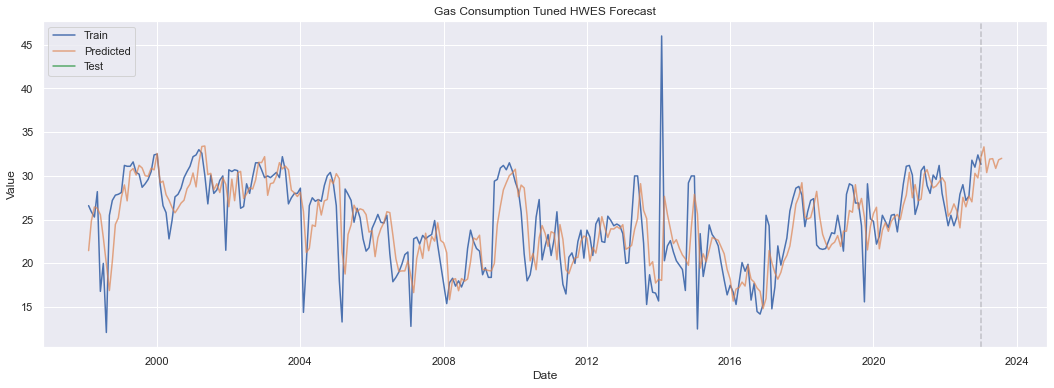

MAE (test): 94.56872272531518
RMSE (test): 94.56872272531518


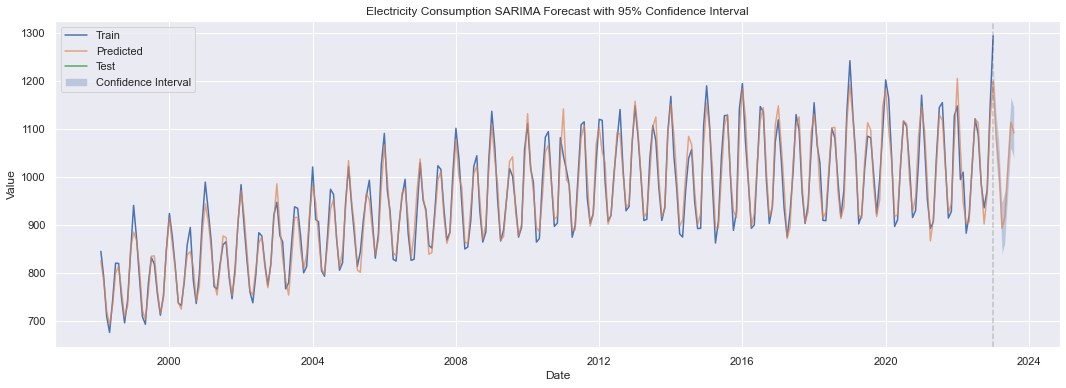

MAE (test): 145.1563526096636
RMSE (test): 145.1563526096636


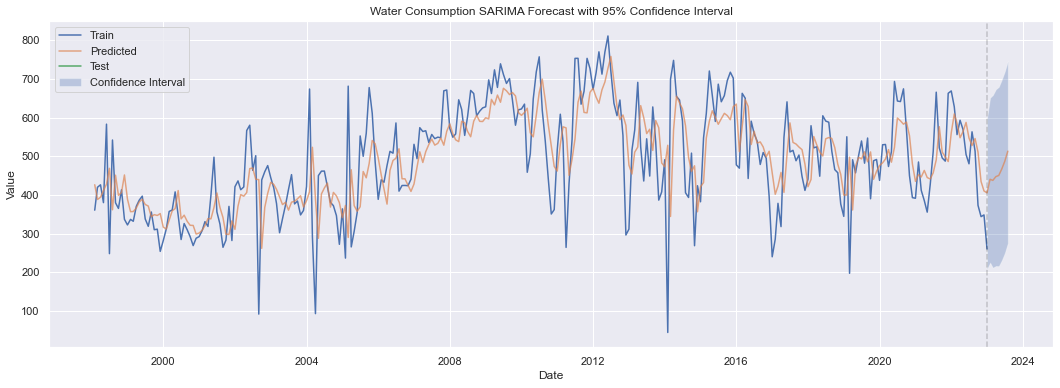

In [86]:
plot_model_params(
    gas_consumption_series, 
    hwes, 
    pickle.load(open(f'pickled/ABC/Gas Consumption/HWES.pkl', 'rb'))._params, 
    gas_pt, 
    title='Gas Consumption Tuned HWES Forecast',
    past_length=300,
    test_length=1,
    forecast_length=6,
    is_hwes=True,
    plot_conf_int=False,
    figsize=(18, 6)
)

plot_model_params(
    electricity_consumption_series, 
    sarimax, 
    pickle.load(open(f'pickled/ABC/Electricity Consumption/SARIMAX.pkl', 'rb'))._params, 
    electricity_pt, 
    title='Electricity Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=300,
    forecast_length=6,
    test_length=1,
    figsize=(18, 6)
)

plot_model_params(
    water_consumption_series, 
    sarimax, 
    pickle.load(open(f'pickled/ABC/Water Consumption/SARIMAX.pkl', 'rb'))._params, 
    water_pt, 
    title='Water Consumption SARIMA Forecast with 95% Confidence Interval',
    past_length=300,
    test_length=1,
    forecast_length=6,
    figsize=(18, 6)
)